In [1]:
# Revenue Exploration and Modeling

# This notebook contains exploratory analysis and modeling for revenue modeling. Part of it creates the following files used in serving the trained model in revenue_model.ipynb:

'models/b_extra_trees_nlp.pkl', 'models/b_feature_names.pkl', 'models/a_extra_trees.pkl', 'models/a_feature_names.pkl'

('models/b_extra_trees_nlp.pkl',
 'models/b_feature_names.pkl',
 'models/a_extra_trees.pkl',
 'models/a_feature_names.pkl')

In [2]:
import os
os.getcwd()

'C:\\Users\\windows10\\AppData\\Local\\Programs\\Python\\Python37\\Scripts'

In [3]:
## Import Libraries

In [2]:
#### Library imports
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# standard imports
import numpy as np
import pandas as pd
import re
import os
import sys
import operator

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, tree, ensemble, svm
from sklearn import metrics, model_selection
import xgboost

In [5]:
## Define functions

# Defining functions that will be used throughout the notebook

In [6]:
# quick function to find regexp patterns in data
def find_string(col_value, string_to_find):
    if pd.isnull(col_value):
        return False
    if re.search(pattern=string_to_find, string=col_value, flags=re.IGNORECASE):
        return True
    else:
        return False


In [7]:
# clean address column with some common issues
addr_fix = [(re.compile('\s+,'), ','),  # remove spaces before comma if exist
            (re.compile(',([^\s])'), ', \g<1>'),  # add space after comma if not exists
            (re.compile('\.'), ''),  # remove .
            (re.compile('^\s+'), ''),  # strip spaces in the beginning
            (re.compile('\s+$'), ''),  # strip spaces at end
            (re.compile('(\s#[^,]*)(,|$)'), '\g<2>'),  # remove unit numbers
            (re.compile('(\d+\s)South(\s\w+\s\w+)', flags=re.IGNORECASE), '\g<1>S\g<2>'),  # contraction, need 2 words after it
            (re.compile('(\d+\s)West(\s\w+\s\w+)', flags=re.IGNORECASE), '\g<1>W\g<2>'),  # contraction, need 2 words after it
            (re.compile('(\d+\s)East(\s\w+\s\w+)', flags=re.IGNORECASE), '\g<1>E\g<2>'),  # contraction, need 2 words after it
            (re.compile('(\d+\s)North(\s\w+\s\w+)', flags=re.IGNORECASE), '\g<1>N\g<2>'),  # contraction, need 2 words after it
            (re.compile('(\W)Street(\W|$)', flags=re.IGNORECASE), '\g<1>St\g<2>'),  # contraction
            (re.compile('(\W)Drive(\W|$)', flags=re.IGNORECASE), '\g<1>Dr\g<2>'),  # contraction
            (re.compile('(\W)Place(\W|$)', flags=re.IGNORECASE), '\g<1>Pl\g<2>'),  # contraction
            (re.compile('(\W)Lane(\W|$)', flags=re.IGNORECASE), '\g<1>Ln\g<2>'),  # contraction
            (re.compile('(\W)Road(\W|$)', flags=re.IGNORECASE), '\g<1>Rd\g<2>'),  # contraction
            (re.compile('([a-zA-Z]{2,}\s)Avenue', flags=re.IGNORECASE), '\g<1>Ave'),  # contraction
            (re.compile('([a-zA-Z]{2,}\s)Parkway(\W|$)', flags=re.IGNORECASE), '\g<1>Pkwy\g<2>'),  # contraction
            (re.compile('([a-zA-Z]{2,}\s)Court', flags=re.IGNORECASE), '\g<1>Ct'),  # contraction
            (re.compile('([a-zA-Z]{2,}\s)Circle', flags=re.IGNORECASE), '\g<1>Cir'),  # contraction
            (re.compile('(\W)Boulevard(\W|$)', flags=re.IGNORECASE), '\g<1>Blvd\g<2>'), # contraction, WARNING: not all shortened in assessor file
           ]

addr_fix_deep = [(re.compile('(\d+\s)S\s(\w+\s\w+)', flags=re.IGNORECASE), '\g<1>\g<2>'),  # remove direction
            (re.compile('(\d+\s)W\s(\w+\s\w+)', flags=re.IGNORECASE), '\g<1>\g<2>'),  # remove direction
            (re.compile('(\d+\s)E\s(\w+\s\w+)', flags=re.IGNORECASE), '\g<1>\g<2>'),  # remove direction
            (re.compile('(\d+\s)N\s(\w+\s\w+)', flags=re.IGNORECASE), '\g<1>\g<2>'),  # remove direction
            ]

def sanitize_address(addr_string):
    new_addr = addr_string
    global addr_fix
    for mypattern in addr_fix:
        new_addr = re.sub(mypattern[0], mypattern[1], new_addr)
    return new_addr

def sanitize_address_deep(addr_string):
    new_addr = addr_string
    global addr_fix
    global addr_fix_deep
    for mypattern in addr_fix:
        new_addr = re.sub(mypattern[0], mypattern[1], new_addr)
    for mypattern in addr_fix_deep:
        new_addr = re.sub(mypattern[0], mypattern[1], new_addr)
    return new_addr


In [8]:
# check for valid address
address_pattern = re.compile('\d{1,5}(\s[\d\w.]+){1,4},\s[\w\s]+,\s\w+\s\d+')

def check_address(addr_string):
    global address_pattern
    if address_pattern.match(addr_string):
        return True
    else:
        return False


In [9]:
# get usable area from area field
area_pattern = re.compile('([\d,]+)')

def get_area(area_str):
    if pd.isnull(area_str):
        return np.nan
    global area_pattern
    area_occurrence = area_pattern.search(area_str)
    if area_occurrence:
        area_num = area_occurrence.groups()[0]
        return int(area_num.replace(',', ''))
    else:
        return np.nan

In [10]:
# get usable rent price from field
price_pattern = re.compile('\$([\d,.]+)')

def get_price(price_str):
    if pd.isnull(price_str):
        return np.nan
    global price_pattern
    price_occurrence = price_pattern.search(price_str)
    if price_occurrence:
        price_num = price_occurrence.groups()[0]
        return float(price_num.replace(',', ''))
    else:
        return np.nan


In [11]:
# get 5-digit Zipcode of property
zip_pattern = re.compile('(\d{5})')

def get_zip_code(zip_str):
    if pd.isnull(zip_str):
        return np.nan
    global zip_pattern
    zip_occurrence = zip_pattern.search(zip_str)
    if zip_occurrence:
        zip_num = zip_occurrence.groups()[0]
        return zip_num
    else:
        return np.nan

In [12]:
# get number of rooms from room string
room_pattern = re.compile('^([\d.]+)')

def room_map(room_str):
    if pd.isnull(room_str):
        return np.nan
    global room_pattern
    addr_occurrence = room_pattern.search(room_str)
    if addr_occurrence:
        return float(addr_occurrence.group())
    elif re.search(pattern='studio', string=room_str, flags=re.IGNORECASE):
        return 0.
    else:
        return np.nan

In [13]:
# cone metric - returns proportion of observations with predictions being within tolerance % of actual
def cone_metric(y_true, y_pred, tolerance=0.1):
    return (np.abs(np.divide((y_pred - y_true), y_true)) < tolerance).mean()

# scorer with cone metric
def cone_score(tolerance=0.1):
    return metrics.make_scorer(cone_metric, tolerance=tolerance)

In [14]:
# sort and deduplicate list of objects (not just scalars!)
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))

In [15]:
# Assessor data (second version - in LA metro)

# Assessor Annual dataset from First American DataTree (ignore DTypeWarning)

In [16]:
# load assessor data - v1
# assessor_data = pd.read_csv('../../../Datasets/current/CA_v1.txt', sep='|', encoding='latin-1')
# assessor_data = assessor_data.dropna(subset=['SitusStdZIP5', 'SitusStdFullStreetAddress'])  # missing addresses

#updated
assessor_data = pd.read_csv('../../../Datasets/current/taxassessor.txt', sep='|', encoding='latin-1')
assessor_data = assessor_data.dropna(subset=['PropertyAddressZIP', 'PropertyAddressFull'])  # missing addresses

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,25,28,32,46,54,56,57,71,78,83,107,112,113,114,115,116,117,118,119,120,121,122,235,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
#updated
assessor_data2 = pd.read_csv('../../../Datasets/current/taxassessor2.txt', sep='|', encoding='latin-1')
assessor_data2 = assessor_data2.dropna(subset=['PropertyAddressZIP', 'PropertyAddressFull'])  # missing addresses

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (25,28,32,46,47,57,78,83,92,107,112,113,114,115,116,117,118,119,120,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
#updated
assessor_data3 = pd.read_csv('../../../Datasets/current/taxassessor3.txt', sep='|', encoding='latin-1')
assessor_data3 = assessor_data3.dropna(subset=['PropertyAddressZIP', 'PropertyAddressFull'])  # missing addresses

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (11,13,18,19,25,26,28,57,78,80,81,83,88,107,112,117,119,120,122,149,157,161) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# load assessor data - v2
# assessor_data2 = pd.read_csv('../../../Datasets/current/CA_v2.txt', sep='|', encoding='latin-1')
# assessor_data2 = assessor_data2.dropna(subset=['SitusStdZIP5', 'SitusStdFullStreetAddress'])  # missing addresses

#updated
assessor_data4 = pd.read_csv('../../../Datasets/current/taxassessor4.txt', sep='|', encoding='latin-1')
assessor_data4 = assessor_data4.dropna(subset=['PropertyAddressZIP', 'PropertyAddressFull'])  # missing addresses



c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (11,13,18,19,21,25,26,28,32,57,78,81,83,88,107,112,117,119,120,122,149,157,161) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
print(assessor_data.shape)

(97815, 318)


In [21]:
assessor_data = pd.concat([assessor_data, assessor_data2, assessor_data3, assessor_data4], axis=0, ignore_index=True)

In [22]:
assessor_data.shape

(347919, 318)

In [23]:
# create sortaddress field which is in the format State ZIP, City, Street
# assessor_data['fullstreetaddress'] = [re.sub(string=e, pattern= ' ' + k + '.*$', repl='', flags=re.IGNORECASE) for e, k in zip(assessor_data.SitusStdFullStreetAddress, assessor_data.SitusStdUnitType.fillna('   ').astype('str'))]
# assessor_data['sortaddress'] = assessor_data['SitusStdState'].str.lower() + ' ' + \
#             assessor_data['SitusStdZIP5'].astype('int').astype('str') + ', ' + \
#             assessor_data['SitusStdCity'].str.lower() + ', ' + assessor_data['fullstreetaddress'].str.lower()
# assessor_data['sortaddress_nocity'] = assessor_data['SitusStdState'].str.lower() + ' ' + \
#             assessor_data['SitusStdZIP5'].astype('int').astype('str') + ', ' + \
#             assessor_data['fullstreetaddress'].str.lower()
# assessor_data['sortaddress_nozip'] = assessor_data['SitusStdState'].str.lower() + ', ' + \
#             assessor_data['SitusStdCity'].str.lower() + ', ' + \
#             assessor_data['fullstreetaddress'].str.lower()
# assessor_data['sortaddress_nocity_deep'] = assessor_data['SitusStdState'].str.lower() + ' ' + \
#             assessor_data['SitusStdZIP5'].astype('int').astype('str') + ', ' + \
#             assessor_data['fullstreetaddress'].apply(sanitize_address_deep).str.lower()
# assessor_data['sortaddress_nozip_deep'] = assessor_data['SitusStdState'].str.lower() + ', ' + \
#             assessor_data['SitusStdCity'].str.lower() + ', ' + \
#             assessor_data['fullstreetaddress'].apply(sanitize_address_deep).str.lower()


# updated

# assessor_data['fullstreetaddress'] = [re.sub(string=e, pattern= ' ' + k + '.*$', repl='', flags=re.IGNORECASE) for e, k in zip(assessor_data.PropertyAddressFull, assessor_data.SitusStdUnitType.fillna('   ').astype('str'))]
assessor_data['sortaddress'] = assessor_data['SitusStateCode'].str.lower() + ' ' + \
            assessor_data['PropertyAddressZIP'].astype('int').astype('str') + ', ' + \
            assessor_data['PropertyAddressCity'].str.lower() + ', ' + assessor_data['PropertyAddressFull'].str.lower()
assessor_data['sortaddress_nocity'] = assessor_data['SitusStateCode'].str.lower() + ' ' + \
            assessor_data['PropertyAddressZIP'].astype('int').astype('str') + ', ' + \
            assessor_data['PropertyAddressFull'].str.lower()
assessor_data['sortaddress_nozip'] = assessor_data['SitusStateCode'].str.lower() + ', ' + \
            assessor_data['PropertyAddressCity'].str.lower() + ', ' + \
            assessor_data['PropertyAddressFull'].str.lower()
assessor_data['sortaddress_nocity_deep'] = assessor_data['SitusStateCode'].str.lower() + ' ' + \
            assessor_data['PropertyAddressZIP'].astype('int').astype('str') + ', ' + \
            assessor_data['PropertyAddressFull'].apply(sanitize_address_deep).str.lower()
assessor_data['sortaddress_nozip_deep'] = assessor_data['SitusStateCode'].str.lower() + ', ' + \
            assessor_data['PropertyAddressCity'].str.lower() + ', ' + \
            assessor_data['PropertyAddressFull'].apply(sanitize_address_deep).str.lower()


assessor_data.sortaddress.head().values

array(['ca 91354, santa clarita, 24347 verdugo cir',
       'ca 91354, santa clarita, 24339 verdugo cir',
       'ca 90704, avalon, kbig radio sta',
       'ca 93535, lancaster, vac/kelly ranch off old ridge dr',
       'ca 91354, santa clarita, 24327 verdugo cir'], dtype=object)

In [24]:
# get basic validity information about assessor data
# print("Number of properties in assessor file:", len(assessor_data))
# print("Properties with non-zero building area:", len(assessor_data[assessor_data.SumBuildingSqFt > 0]))
# print("Properties with non-zero number of residential units:", len(assessor_data[assessor_data.SumResidentialUnits > 0]))
# print("Properties with non-zero number of rooms:", len(assessor_data[assessor_data.Bedrooms > 0]))
# print("Properties with non-zero number of bathrooms:", len(assessor_data[assessor_data.BathTotalCalc > 0]))
# print("Properties with bedrooms >= units:", len(assessor_data[(assessor_data.SumResidentialUnits > 0) & (assessor_data.Bedrooms >= assessor_data.SumResidentialUnits)]))
# print("Properties with bathrooms >= units:", len(assessor_data[(assessor_data.SumResidentialUnits > 0) & (assessor_data.BathTotalCalc >= assessor_data.SumResidentialUnits)]))
# print("Valid properties (satisfying all of the above:", len(assessor_data[(assessor_data.SumBuildingSqFt > 0) & (assessor_data.SumResidentialUnits > 0) &
#              (assessor_data.Bedrooms > 0) & (assessor_data.BathTotalCalc > 0) &
#              (assessor_data.Bedrooms >= assessor_data.SumResidentialUnits) &
#              (assessor_data.BathTotalCalc >= assessor_data.SumResidentialUnits)]))


# updated
print("Number of properties in assessor file:", len(assessor_data))
print("Properties with non-zero building area:", len(assessor_data[assessor_data.AreaBuilding > 0]))
print("Properties with non-zero number of residential units:", len(assessor_data[assessor_data.UnitsCount > 0]))
print("Properties with non-zero number of rooms:", len(assessor_data[assessor_data.BedroomsCount > 0]))
print("Properties with non-zero number of bathrooms:", len(assessor_data[assessor_data.BathCount > 0]))
print("Properties with bedrooms >= units:", len(assessor_data[(assessor_data.UnitsCount > 0) & (assessor_data.BedroomsCount >= assessor_data.UnitsCount)]))
print("Properties with bathrooms >= units:", len(assessor_data[(assessor_data.UnitsCount > 0) & (assessor_data.BathCount >= assessor_data.UnitsCount)]))
print("Valid properties (satisfying all of the above:", len(assessor_data[(assessor_data.AreaBuilding > 0) & (assessor_data.UnitsCount > 0) &
             (assessor_data.BedroomsCount > 0) & (assessor_data.BathCount > 0) &
             (assessor_data.BedroomsCount >= assessor_data.UnitsCount) &
             (assessor_data.BathCount >= assessor_data.UnitsCount)]))

Number of properties in assessor file: 347919
Properties with non-zero building area: 326997
Properties with non-zero number of residential units: 279190
Properties with non-zero number of rooms: 313214
Properties with non-zero number of bathrooms: 314127
Properties with bedrooms >= units: 269157
Properties with bathrooms >= units: 267946
Valid properties (satisfying all of the above: 265550


In [25]:
# valid assessor data
# assessor_data_super_valid = assessor_data[(assessor_data.SumBuildingSqFt > 0) & (assessor_data.SumResidentialUnits > 0) &
#              (assessor_data.Bedrooms > 0) & (assessor_data.BathTotalCalc > 0) &
#              (assessor_data.Bedrooms >= assessor_data.SumResidentialUnits) &
#              (assessor_data.BathTotalCalc >= assessor_data.SumResidentialUnits)].copy()
# assessor_data_valid = assessor_data[(assessor_data.SumBuildingSqFt > 0) & (assessor_data.SumResidentialUnits > 0)].copy()

# updated
assessor_data_super_valid = assessor_data[(assessor_data.AreaBuilding > 0) & (assessor_data.UnitsCount > 0) &
             (assessor_data.BedroomsCount > 0) & (assessor_data.BathCount > 0) &
             (assessor_data.BedroomsCount >= assessor_data.UnitsCount) &
             (assessor_data.BathCount >= assessor_data.UnitsCount)].copy()
assessor_data_valid = assessor_data[(assessor_data.AreaBuilding > 0) & (assessor_data.UnitsCount > 0)].copy()

In [26]:
# match in sortaddress_nocity_deep
# assessor_data[assessor_data.sortaddress_nocity_deep == 'ca 90007, 2667 ellendale pl'][['PropertyID','SitusStdFullStreetAddress','YearBuilt','EffectiveYearBuilt', 'SumBuildingSqFt', 'SumLivingAreaSqFt', 'SumGrossAreaSqFt',
#        'SumResidentialUnits', 'Bedrooms', 'TotalRooms', 'BathTotalCalc', 'BathFull', 'BathsParcialNbr', 'BathFixturesNbr']]



In [27]:
# assessor_data[(assessor_data.CurrSaleRecordingDate > 20160000) & (assessor_data.StdLandUseCode != 1004)].groupby('SitusStdZIP5').FIPS.count().to_csv('CurrSaleRecordingDate_2017.csv')

In [28]:
## alternative quick load relevant assessor data
# relevant_assessor_data = assessor_data[['FIPS', 'PropertyID', 'SitusStdFullStreetAddress', 'SitusStdHouseNbr',
#        'SitusStdHouseNbrSuffix', 'SitusStdDirectionLeft', 'SitusStdStreet',
#        'SitusStdMode', 'SitusStdDirectionRight', 'SitusStdUnitType',
#        'SitusStdUnitNbr', 'SitusStdCity', 'SitusStdState', 'SitusStdZIP5',
#        'SitusStdZIP4', 'SitusStdCarrierCode', 'SitusLatitude',
#        'SitusLongitude', 'SumBuildingSqFt', 'SumLivingAreaSqFt', 'SumGrossAreaSqFt',
#        'SumAdjAreaSqFt', 'SumBasementSqFt', 'SumGarageSqFt', 'YearBuilt',
#        'EffectiveYearBuilt', 'SumResidentialUnits', 'Bedrooms', 'TotalRooms', 'BathTotalCalc',
#        'BathFull', 'BathsParcialNbr', 'BathFixturesNbr', 'LotSizeAcres', 'LotSizeSqFt',
#        'FormattedAPN', 'StdLandUseCode', 'CountyLandUseCode', 'Zoning', 'AssdTotalValue',
#        'AssdLandValue', 'AssdImprovementValue', 'MarketTotalValue', 'MarketValueLand',
#        'MarketValueImprovement', 'TaxAmount', 'TaxYear', 'CurrSaleRecordingDate',
#        'CurrSaleContractDate', 'CurrSalesPrice',
#        'fullstreetaddress', 'sortaddress', 'sortaddress_nocity',
#        'sortaddress_nozip', 'sortaddress_nocity_deep',
#        'sortaddress_nozip_deep']].copy()
# relevant_assessor_data.to_csv('../../../Datasets/current/assessor.csv', index=False)
# assessor_data = pd.read_csv('../../../Datasets/current/assessor.csv')
#haris: comment out , use assessor data from txt files
# assessor_data = pd.read_csv('E:/projects/New folder/Datasets/current/assessor.csv')

In [29]:
# small_assessor_data = assessor_data[(assessor_data.CurrSaleRecordingDate > 20170000) & (assessor_data.StdLandUseCode != 1004)].copy().reset_index(drop=True)
# updated
small_assessor_data = assessor_data.copy().reset_index(drop=True)

In [30]:
print(small_assessor_data.shape)


(347919, 323)


In [31]:
(small_assessor_data.PropertyAddressZIP==90035).sum()

578

In [32]:
# sample search with partial text matching (actually, regex matching)
# small_assessor_data[small_assessor_data.sortaddress.apply(find_string, args=('20341 harvard',))][['EffectiveYearBuilt', 'SumResidentialUnits']]


In [33]:
# First crawl file (from first set)

# Cleaner dataset of the two files in the first dataset

# From Rental Crawl Sample - RJ.csv

In [40]:
# load data
# crawl_data = pd.read_csv('../../../Datasets/current/Rental Crawl Sample - RJ.csv', header=None)
# crawl_data = pd.read_csv('E:/projects/New folder/Datasets/current/Rental Crawl Sample - RJ.csv', header=None)

# crawl_data.columns = ["name", "address", "description", "bedroom", "bathroom", "area", "rentalprice",
#                       "altbedroom", "altbathroom", "altarea", "altrentalprice"]

In [41]:
# get idea of data
# print(crawl_data.head(3))

                                                name  \
0  Rental Apartment 245 N. Alvarado St. (2 2) Los...   
1  Rental Apartment 301 N. Alvarado St. (2 2) Los...   
2                               Ellendale Apartments   

                                    address  \
0                      CA 90026 Los Angeles   
1  301 N Alvarado St, Los Angeles, CA 90026   
2  2656 Ellendale Pl, Los Angeles, CA 90007   

                                         description     bedroom     bathroom  \
0  2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...  2 Bed room  2 Bath room   
1  2 BEDROOM + 2 BATHROOM Modern / Controlled Acc...  2 Bed room  2 Bath room   
2  $1500 OFF MOVE-INEllendale is conveniently loc...  2 Bed room  2 Bath room   

            area rentalprice altbedroom altbathroom altarea altrentalprice  
0  1,000 sq . ft     $1,700         NaN         NaN     NaN            NaN  
1  1,000 sq . ft     $1,750         NaN         NaN     NaN            NaN  
2  1,000 sq . ft     $2,895   

In [42]:
# get summary description of data
# print(crawl_data.describe())

                                      name            address description  \
count                                 9964               9964        9792   
unique                                6855               5938        8399   
top     Apartment for rent in Los Angeles.  Alameda, CA 94501     #ERROR!   
freq                                   218                 70          52   

           bedroom     bathroom           area rentalprice  altbedroom  \
count         9707         8822           3056        9716         273   
unique           7           14            936        1678           6   
top     2 Bed room  1 Bath room  1,000 sq . ft         Ask  1 Bed room   
freq          3604         5719            117         723         133   

        altbathroom      altarea altrentalprice  
count           252          162            277  
unique            6          129            218  
top     1 Bath room  900 sq . ft        $2,350   
freq            184            5           

In [43]:
# sanitize addresses
# crawl_data['address'] = crawl_data['address'].apply(sanitize_address)

In [44]:
# check in how many cases address is valid
# print("Valid address:")
# print(crawl_data.address.apply(check_address).value_counts())

Valid address:
False    5459
True     4505
Name: address, dtype: int64


In [45]:
# create new dataaset with just the valid address data
# crawl_data_valid = crawl_data[crawl_data.address.apply(check_address)]
# crawl_data_valid = crawl_data_valid.reset_index(drop=True)

In [46]:
# get summary description of valid data
# print(crawl_data_valid.describe())

                                                     name  \
count                                                4505   
unique                                               3638   
top     Apartment for rent in Los Angeles CA, - Los An...   
freq                                                   32   

                                             address description     bedroom  \
count                                           4505        4348        4346   
unique                                          3469        3450           6   
top     1331 S Los Angeles St, Los Angeles, CA 90015     #ERROR!  2 Bed room   
freq                                              36          49        1634   

           bathroom           area rentalprice  altbedroom  altbathroom  \
count          3600           1445        4355         265          247   
unique           11            581        1038           5            5   
top     1 Bath room  1,000 sq . ft         Ask  1 Bed room  1 Bath r

In [47]:
# convert number of bedrooms to usable field
# bedroom_map = {'2 Bed room': 2, '1 Bed room': 1, '3 Bed room': 3, 'S tudio': 0,
#                '4 Bed room': 4, '2.5 Bed room': 2, 'Field_04': np.nan}
# crawl_data_valid['bd'] = crawl_data_valid['bedroom'].map(bedroom_map)
# crawl_data_valid['altbd'] = crawl_data_valid['altbedroom'].map(bedroom_map)

In [48]:
# convert number of bathrooms to usable field
# crawl_data_valid['ba'] = crawl_data_valid.bathroom.apply(room_map)
# crawl_data_valid['altba'] = crawl_data_valid.altbathroom.apply(room_map)

In [49]:
# convert area to usable field
# crawl_data_valid['ar'] = crawl_data_valid.area.apply(get_area)
# crawl_data_valid['altar'] = crawl_data_valid.altarea.apply(get_area)

In [50]:
# convert rental price to usable field
# crawl_data_valid['pr'] = crawl_data_valid.rentalprice.apply(get_price)
# crawl_data_valid['altpr'] = crawl_data_valid.altrentalprice.apply(get_price)

In [51]:
# get zip code of property
# crawl_data_valid['zip'] = crawl_data_valid.address.apply(get_zip_code).astype('str')
# crawl_data_valid.zip.value_counts()

In [52]:
# create new columns from data
# crawl_address_cols = crawl_data_valid.address.apply(lambda x: pd.Series(x.lower().split(', ')))
# crawl_address_cols.rename(columns={0:'astreet', 1:'acity', 2:'azipstate'},inplace=True)
# crawl_address_cols['sortaddress'] = crawl_address_cols[['azipstate', 'acity', 'astreet']].apply(lambda x: ', '.join(x), axis = 1)

In [53]:
# merge new columns with existing dataset
# crawl_data_valid = pd.concat([crawl_data_valid, crawl_address_cols], axis=1)

In [54]:
# aggregated information by zip code and number of bedrooms
# zip_bd_group_data = crawl_data_valid.groupby(['zip', 'bd'])
# zip_bd_group_data.filter(lambda x: x['ar'].count() > 5).groupby(['zip', 'bd']).ar.describe()

count         mean         std     min      25%     50%      75%  \
zip   bd                                                                      
90004 2.0    6.0  1290.666667  363.673847   980.0  1100.00  1127.0  1376.00   
90015 0.0    8.0   502.000000  177.074641   164.0   453.50   498.5   613.50   
      1.0    8.0   901.625000  197.001768   669.0   739.50   897.0  1100.00   
      2.0   10.0  1421.100000  742.899791   310.0   966.00  1311.0  1662.50   
90017 0.0    8.0   359.375000  103.812933   150.0   318.75   375.0   439.00   
90024 1.0    7.0   801.571429  124.490772   650.0   722.00   800.0   843.50   
      2.0    8.0  1119.000000  278.958778   833.0   932.25   999.0  1264.50   
90025 2.0   10.0  1221.700000  280.241582   912.0  1036.25  1100.0  1401.50   
90026 1.0    6.0   753.166667  168.345379   600.0   662.50   700.0   775.00   
90028 0.0    8.0   432.250000   93.247367   300.0   362.75   450.0   505.75   
      1.0   17.0   873.823529  376.404908   526.0   626.00   710.0  1000.00   
      2.0   18.0  1153.111111  478.544962   650.0   882.00  1053.5  1194.00   
      3.0    7.0  1678.571429  612.952379   882.0  1375.00  1625.0  1848.50   
90029 1.0    6.0   861.166667  561.811505   470.0   531.25   725.0   787.50   
90034 2.0   10.0  1059.800000  127.599025   863.0   985.00  1055.0  1100.00   
90035 2.0    9.0  1148.777778  153.724411   900.0  1100.00  1200.0  1227.00   
      3.0    6.0  1959.666667  358.776625  1400.0  1850.00  2000.0  2043.50   
90036 1.0   14.0   785.142857  104.823557   650.0   720.00   737.5   850.00   
      2.0   13.0  1213.230769  219.320600  1000.0  1134.00  1150.0  1215.00   
90045 1.0    7.0   727.142857   91.008111   589.0   675.00   735.0   775.00   
      2.0    6.0  1039.333333  189.717334   800.0   942.00  1002.5  1123.75   
90046 1.0   12.0   913.666667   99.048504   800.0   843.00   882.5  1000.00   
      2.0   14.0  1246.357143  297.427847   950.0  1000.00  1200.0  1444.75   
90048 1.0    6.0   810.166667   93.482440   675.0   764.25   815.0   850.00   
      2.0    9.0  1200.333333   89.534909  1000.0  1200.00  1248.0  1250.00   
90069 2.0    6.0  1351.500000  409.660225   950.0  1055.00  1260.0  1525.00   
90212 2.0    6.0  1363.500000  639.701102   340.0  1250.00  1425.0  1450.00   
90277 1.0    7.0   781.000000  202.015676   542.0   680.00   725.0   845.00   
90291 2.0    6.0   862.000000   80.229670   775.0   829.00   829.0   889.75   
90401 0.0    8.0   424.125000   87.624911   305.0   337.00   451.5   501.75   
      1.0    7.0   573.571429  121.423305   397.0   502.00   625.0   649.00   
      2.0    7.0   903.428571  122.485179   786.0   825.50   880.0   927.50   
90403 1.0    8.0   807.875000  140.194189   622.0   687.50   813.0   938.00   
90405 1.0    8.0   661.500000  168.389854   375.0   600.25   667.5   766.25   
90802 0.0   10.0   484.800000  124.796546   220.0   412.50   531.5   578.00   
      1.0   15.0   777.133333  166.543802   570.0   660.00   740.0   909.00   
      2.0   14.0  1058.214286  217.546168   750.0   962.50  1040.0  1105.50   
91304 2.0    7.0   910.857143  101.856809   830.0   850.00   850.0   941.50   
91316 2.0   10.0  1277.100000  160.808686  1000.0  1205.00  1374.0  1374.00   
91423 2.0    6.0  1257.833333  273.425249  1048.0  1119.25  1194.0  1211.00   
94501 2.0    9.0   941.111111  148.764448   773.0   825.00   900.0  1050.00   

              max  
zip   bd           
90004 2.0  1960.0  
90015 0.0   721.0  
      1.0  1100.0  
      2.0  2828.0  
90017 0.0   468.0  
90024 1.0  1030.0  
      2.0  1608.0  
90025 2.0  1823.0  
90026 1.0  1069.0  
90028 0.0   534.0  
      1.0  1910.0  
      2.0  2248.0  
      3.0  2796.0  
90029 1.0  1972.0  
90034 2.0  1300.0  
90035 2.0  1400.0  
      3.0  2500.0  
90036 1.0  1010.0  
      2.0  1700.0  
90045 1.0   866.0  
      2.0  1345.0  
90046 1.0  1100.0  
      2.0  1777.0  
90048 1.0   947.0  
      2.0  1277.0  
90069 2.0  2039.0  
90212 2.0  2341.0  
90277 1.0  1150.0  
90291 2.0  10

In [55]:
# How many are in assessor data?
# print("Unique properties in assessor data:", assessor_data.sortaddress.isin(crawl_data_valid.sortaddress.values).sum()/float(len(crawl_data_valid)))
# print("Common units in assessor data:", crawl_data_valid.sortaddress.isin(assessor_data.sortaddress.values).sum()/float(len(crawl_data_valid)))

Unique properties in assessor data: 0.030854605993340733
Common units in assessor data: 0.03374028856825749


In [34]:
# Crawl dataset 4 (from second set)

# From 5195689920471874184-1.xlsx

In [35]:
# load data and add state information
# crawl_data4 = pd.read_csv('../../../Datasets/current/5195689920471874184-1.csv')
# crawl_data4 = pd.read_csv('E:/projects/New folder/Datasets/current/5195689920471874184-1.csv')

# crawl_data4['addr_state'] = 'CA'

In [58]:
# get summary information about crawled data
# print("Number of rows:", len(crawl_data4))
# print(crawl_data4.isnull().sum())

# print(crawl_data4.head())

Number of rows: 14824
Date Posted/Listed                   3166
Address (number)                     3522
Address (street name)                3166
City                                 3166
Zip Code                             3166
Total Number Units (if available)    3166
Unit Price                           3166
Bedroom Count                        3166
Bathroom Count                       3166
Unit Size (sf)                       3166
Description (free text)              3466
Amenities/Features (if available)    3709
addr_state                              0
dtype: int64
                        Date Posted/Listed  Address (number)  \
0                                      NaN               NaN   
1  Posted 23 days ago\rUpdated 18 days ago           24979.0   
2  Posted 23 days ago\rUpdated 18 days ago           24979.0   
3  Posted 23 days ago\rUpdated 18 days ago           24979.0   
4                                      NaN               NaN   

  Address (street name)           

In [59]:
# remove missing data
# crawl_data4_valid = crawl_data4[crawl_data4['Zip Code'].notnull() & crawl_data4['City'].notnull() & \
#                                crawl_data4['Address (street name)'].notnull() & crawl_data4['Address (number)'].notnull()]
# crawl_data4_valid = crawl_data4_valid.reset_index(drop=True)
# crawl_data4_valid.isnull().sum()

Date Posted/Listed                     0
Address (number)                       0
Address (street name)                  0
City                                   0
Zip Code                               0
Total Number Units (if available)      0
Unit Price                             0
Bedroom Count                          0
Bathroom Count                         0
Unit Size (sf)                         0
Description (free text)              296
Amenities/Features (if available)    526
addr_state                             0
dtype: int64

In [60]:
# clean up zip codes and strip spaces
# crawl_data4_valid['addr_zip'] = crawl_data4_valid['Zip Code'].apply(get_zip_code).astype('int')
# crawl_data4_valid['addr_city'] = crawl_data4_valid['City'].str.strip()
# crawl_data4_valid['addr_streetname'] = crawl_data4_valid['Address (street name)'].apply(sanitize_address)

In [61]:
# create sortaddress column
# crawl_data4_valid['sortaddress'] = crawl_data4_valid['addr_state'].str.lower() + ' ' + \
#             crawl_data4_valid['addr_zip'].astype('int').astype('str') + ', ' + \
#             crawl_data4_valid['addr_city'].str.lower() + ', ' + \
#             crawl_data4_valid['Address (number)'].astype('int').astype('str') + ' ' + \
#             crawl_data4_valid['addr_streetname'].str.lower()
# crawl_data4_valid['sortaddress_nocity'] = crawl_data4_valid['addr_state'].str.lower() + ' ' + \
#             crawl_data4_valid['addr_zip'].astype('int').astype('str') + ', ' + \
#             crawl_data4_valid['Address (number)'].astype('int').astype('str') + ' ' + \
#             crawl_data4_valid['addr_streetname'].str.lower()
# crawl_data4_valid['sortaddress_nocity_deep'] = crawl_data4_valid['sortaddress_nocity'].apply(sanitize_address_deep)
# crawl_data4_valid.sortaddress.head(1)

0    ca 91381, stevenson ranch, 24979 constitution ave
Name: sortaddress, dtype: object

In [62]:
# How many are in assessor data?
# print("Unique properties in assessor data:", assessor_data.sortaddress.isin(crawl_data4_valid.sortaddress.values).sum()/float(len(crawl_data4_valid)))
# print("Common units in assessor data:", crawl_data4_valid.sortaddress.isin(assessor_data.sortaddress.values).sum()/float(len(crawl_data4_valid)))

# print("Unique properties in assessor data (city ignored):", assessor_data.sortaddress_nocity.isin(crawl_data4_valid.sortaddress_nocity.values).sum()/float(len(crawl_data4_valid)))
# print("Common units in assessor data (city ignored):", crawl_data4_valid.sortaddress_nocity.isin(assessor_data.sortaddress_nocity.values).sum()/float(len(crawl_data4_valid)))

# print("Unique properties in assessor data (city and direction ignored):", assessor_data.sortaddress_nocity_deep.isin(crawl_data4_valid.sortaddress_nocity_deep.values).sum()/float(len(crawl_data4_valid)))
# print("Common units in assessor data (city and direction ignored):", crawl_data4_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values).sum()/float(len(crawl_data4_valid)))

Unique properties in assessor data: 0.025393735622013802
Common units in assessor data: 0.10511413909042647
Unique properties in assessor data (city ignored): 0.026543974517784463
Common units in assessor data (city ignored): 0.11236949212528756
Unique properties in assessor data (city and direction ignored): 0.06069722173066714
Common units in assessor data (city and direction ignored): 0.12679171827995045


In [63]:
# crawl_data4_valid[['sortaddress']].head(5).values

array([['ca 91381, stevenson ranch, 24979 constitution ave'],
       ['ca 91381, stevenson ranch, 24979 constitution ave'],
       ['ca 91381, stevenson ranch, 24979 constitution ave'],
       ['ca 91381, newhall, 25238 steinbeck ave'],
       ['ca 91381, newhall, 25218 steinbeck ave']], dtype=object)

In [36]:
# Crawl dataset 5 (from second set)

# From 2166126669592451721-1.xlsx

In [65]:
# load data and add state information
# crawl_data5 = pd.read_csv('../../../Datasets/current/2166126669592451721-1.csv')
# crawl_data5 = pd.read_csv('E:/projects/New folder/Datasets/current/2166126669592451721-1.csv')

# crawl_data5['addr_state'] = 'CA'

In [66]:
# get summary information about crawled data
# print("Number of rows:", len(crawl_data5))
# print(crawl_data5.isnull().sum())

# print(crawl_data5.head())

Number of rows: 21370
Date Posted/Listed                   4314
Address (number)                     4943
Address (street name)                4314
City                                 4314
Zip Code                             4314
Total Number Units (if available)    4314
Unit Price                           4314
Bedroom Count                        4314
Bathroom Count                       4314
Unit Size (sf)                       4314
Description (free text)              4825
Amenities/Features (if available)    5231
addr_state                              0
dtype: int64
                        Date Posted/Listed  Address (number)  \
0                                      NaN               NaN   
1  Posted 23 days ago\rUpdated 18 days ago           24979.0   
2  Posted 23 days ago\rUpdated 18 days ago           24979.0   
3  Posted 23 days ago\rUpdated 18 days ago           24979.0   
4                                      NaN               NaN   

  Address (street name)           

In [67]:
# remove missing data (1st time out of 2)
# crawl_data5_valid = crawl_data5[crawl_data5['Zip Code'].notnull() & crawl_data5['City'].notnull() & \
#                                crawl_data5['Address (street name)'].notnull() & crawl_data5['Address (number)'].notnull()].copy()
# crawl_data5_valid = crawl_data5_valid.reset_index(drop=True)
# print(crawl_data5_valid.isnull().sum())

Date Posted/Listed                     0
Address (number)                       0
Address (street name)                  0
City                                   0
Zip Code                               0
Total Number Units (if available)      0
Unit Price                             0
Bedroom Count                          0
Bathroom Count                         0
Unit Size (sf)                         0
Description (free text)              504
Amenities/Features (if available)    886
addr_state                             0
dtype: int64


In [68]:
# remove duplicates (NOTE: CANNOT DO THIS BECAUSE MULTIPLE UNITS IN SAME PROPERTY EXIST)
# print "Proporion of unique entries:", len(crawl_data5_valid.drop_duplicates(subset = ['Address (number)', 'Address (street name)', 'Zip Code']))/float(len(crawl_data5_valid))
# crawl_data5_valid = crawl_data5_valid.drop_duplicates(subset = ['Address (number)', 'Address (street name)', 'Zip Code'])


In [69]:
# clean up zip codes, unit area, strip spaces from city, sanitize address, clean rental price, bedrooms and bathrooms
# crawl_data5_valid['addr_zip'] = crawl_data5_valid['Zip Code'].apply(get_zip_code).astype('int')
# crawl_data5_valid['addr_area'] = crawl_data5_valid['Unit Size (sf)'].apply(get_area)
# crawl_data5_valid['addr_city'] = crawl_data5_valid['City'].str.strip()
# crawl_data5_valid['addr_streetname'] = crawl_data5_valid['Address (street name)'].apply(sanitize_address)
# crawl_data5_valid['addr_price'] = crawl_data5_valid['Unit Price'].apply(get_price)
# crawl_data5_valid['addr_bd'] = crawl_data5_valid['Bedroom Count'].apply(room_map)
# crawl_data5_valid['addr_ba'] = crawl_data5_valid['Bathroom Count'].apply(room_map)

In [70]:
# remove missing data again (2nd time - FINAL)
# crawl_data5_valid = crawl_data5_valid[crawl_data5_valid.addr_area.notnull() & crawl_data5_valid.addr_price.notnull()]
# crawl_data5_valid = crawl_data5_valid.reset_index(drop=True)
# print(len(crawl_data5_valid))

12616


In [71]:
# create sortaddress column
# crawl_data5_valid['sortaddress'] = crawl_data5_valid['addr_state'].str.lower() + ' ' + \
#             crawl_data5_valid['addr_zip'].astype('int').astype('str') + ', ' + \
#             crawl_data5_valid['addr_city'].str.lower() + ', ' + \
#             crawl_data5_valid['Address (number)'].astype('int').astype('str') + ' ' + \
#             crawl_data5_valid['addr_streetname'].str.lower()
# crawl_data5_valid['sortaddress_nocity'] = crawl_data5_valid['addr_state'].str.lower() + ' ' + \
#             crawl_data5_valid['addr_zip'].astype('int').astype('str') + ', ' + \
#             crawl_data5_valid['Address (number)'].astype('int').astype('str') + ' ' + \
#             crawl_data5_valid['addr_streetname'].str.lower()
# crawl_data5_valid['sortaddress_nozip'] = crawl_data5_valid['addr_state'].str.lower() + ', ' + \
#             crawl_data5_valid['addr_city'].str.lower() + ', ' + \
#             crawl_data5_valid['Address (number)'].astype('int').astype('str') + ' ' + \
#             crawl_data5_valid['addr_streetname'].str.lower()
# crawl_data5_valid['sortaddress_nocity_deep'] = crawl_data5_valid['sortaddress_nocity'].apply(sanitize_address_deep)
# crawl_data5_valid['sortaddress_nozip_deep'] = crawl_data5_valid['sortaddress_nozip'].apply(sanitize_address_deep)

# crawl_data5_valid.sortaddress.head(1)

0    ca 91381, stevenson ranch, 24979 constitution ave
Name: sortaddress, dtype: object

In [72]:
# How many are in assessor data?
# print("Unique properties in assessor data:", assessor_data.sortaddress.isin(crawl_data5_valid.sortaddress.values).sum()/float(len(crawl_data5_valid)))
# print("Common units in assessor data:", crawl_data5_valid.sortaddress.isin(assessor_data.sortaddress.values).sum()/float(len(crawl_data5_valid)))

# print("Unique properties in assessor data (city ignored):", assessor_data.sortaddress_nocity.isin(crawl_data5_valid.sortaddress_nocity.values).sum()/float(len(crawl_data5_valid)))
# print("Common units in assessor data (city ignored):", crawl_data5_valid.sortaddress_nocity.isin(assessor_data.sortaddress_nocity.values).sum()/float(len(crawl_data5_valid)))

# print("Unique properties in assessor data (city and direction ignored):", assessor_data.sortaddress_nocity_deep.isin(crawl_data5_valid.sortaddress_nocity_deep.values).sum()/float(len(crawl_data5_valid)))
# print("Common units in assessor data (city and direction ignored):", crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values).sum()/float(len(crawl_data5_valid)))

# print("Common units in assessor data (city/zip ignored and direction ignored):", len(crawl_data5_valid[(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True) | (crawl_data5_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == True)]) / float(len(crawl_data5_valid)))


Unique properties in assessor data: 0.025047558655675334
Common units in assessor data: 0.1012999365884591
Unique properties in assessor data (city ignored): 0.026553582752060875
Common units in assessor data (city ignored): 0.11065313887127458
Unique properties in assessor data (city and direction ignored): 0.07974001268230818
Common units in assessor data (city and direction ignored): 0.12785351934051997
Common units in assessor data (city/zip ignored and direction ignored): 0.13173747622067217


In [73]:
# crawl_data5_valid[(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == False) & (crawl_data5_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == False)].sortaddress.unique()[0:10]

array(['ca 91381, stevenson ranch, 24979 constitution ave',
       'ca 91381, newhall, 25238 steinbeck ave',
       'ca 91381, newhall, 25218 steinbeck ave',
       'ca 91381, stevenson ranch, 25951 stafford canyon rd',
       'ca 91381, stevenson ranch, 25935 stafford canyon rd',
       'ca 91381, stevenson ranch, 25760 perlman pl',
       'ca 91381, stevenson ranch, 25250 steinbeck ave',
       'ca 91381, stevenson ranch, 25754 perlman pl',
       'ca 91387, canyon country, 18701 flying tiger dr',
       'ca 91387, santa clarita, 28856 n silver saddle cir'], dtype=object)

In [74]:
# D_False = crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == False].addr_zip.value_counts().to_dict()
# D_True = crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True].addr_zip.value_counts().to_dict()

# crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == False].addr_zip.value_counts().to_csv('../results/D_False.csv', index=False)
# crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True].addr_zip.value_counts().to_csv('../results/D_True.csv', index=False)
# crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == False].addr_zip.value_counts().to_csv('E:/projects/New folder/Models/Revenue/results/D_False.csv', index=False)
# crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True].addr_zip.value_counts().to_csv('E:/projects/New folder/Models/Revenue/results/D_True.csv', index=False)


In [75]:
# print("Number of matches with assessor data:", crawl_data5_valid[(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True) | (crawl_data5_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == True)]['sortaddress'].shape)
# print("Number of matches with valid assessor data:", crawl_data5_valid[(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data_valid.sortaddress_nocity_deep.values) == True) | (crawl_data5_valid.sortaddress_nozip_deep.isin(assessor_data_valid.sortaddress_nozip_deep.values) == True)]['sortaddress'].shape)

Number of matches with assessor data: (1662,)
Number of matches with valid assessor data: (1238,)


In [77]:
# example of missing assessor data (number of residential units)
# assessor_data[assessor_data.sortaddress.isin(crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) & ~(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data_valid.sortaddress_nocity_deep.values))]['sortaddress'].values)][['PropertyID','SitusStdFullStreetAddress','YearBuilt','EffectiveYearBuilt', 'SumBuildingSqFt', 'SumLivingAreaSqFt', 'SumGrossAreaSqFt',
#        'SumResidentialUnits', 'Bedrooms', 'TotalRooms', 'BathTotalCalc', 'BathFull', 'BathsParcialNbr', 'BathFixturesNbr']].head(10)
# assessor_data[assessor_data.sortaddress.isin(crawl_data5_valid[crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) & ~(crawl_data5_valid.sortaddress_nocity_deep.isin(assessor_data_valid.sortaddress_nocity_deep.values))]['sortaddress'].values)][['ID','PropertyAddressFull','YearBuilt','YearBuiltEffective', 'AreaBuilding', 'AreaBuilding', 'AreaGross',
#        'UnitsCount', 'BedroomsCount', 'RoomsCount', 'BathCount', 'BathCount', 'BathPartialCount']].head(10)

,ID,PropertyAddressFull,YearBuilt,YearBuiltEffective,AreaBuilding,AreaBuilding,AreaGross,UnitsCount,BedroomsCount,RoomsCount,BathCount,BathCount,BathPartialCount
706,239774774,321 N ORANGE ST,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
3507,251911913,1217 HORN AVE,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
10491,323432473,422 W ROUTE 66,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
13871,251911545,3215 VISTA DR,2014.0,2014.0,2340,2340,0.0,0.0,0,0.0,0.0,0.0,0
14636,323429670,232 E 2ND ST,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
14637,323429671,232 E 2ND ST,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
15127,251911858,5550 HOLLYWOOD BLVD,1921.0,1950.0,8400,8400,8400.0,0.0,0,0.0,0.0,0.0,0
15737,253540476,232 E 2ND ST,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
18364,154598014,10833 WILSHIRE BLVD,NaN,NaN,0,0,0.0,0.0,0,0.0,0.0,0.0,0
19677,154783211,633 N CENTRAL AVE,1957.0,1957.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0


In [37]:
# Crawl Data 6 - USE THIS ONE

# From 3rd set - results.csv (11/26, updated: 12/04)

In [7]:
# crawl_data6 = pd.read_csv('../../../Datasets/current/results_with_links.csv')
# crawl_data6 = pd.read_csv('E:/projects/New folder/Datasets/current/results_with_links.csv')

# udated- load crawler data from mongo
# import pymongo
# from pymongo import MongoClient
# from pandas.io.json import json_normalize
# data = MongoClient('localhost', 27017)
# db = data.mydb
# crawl_data6 = json_normalize(list(db.links.find()))
# crawl_data6 = crawl_data6.drop(columns=['_id','id'])
# crawl_data6['addr_state'] = 'CA'
# crawl_data6.replace('', np.nan, inplace=True)

# updated- load crawler from file
crawl_data6 = pd.read_csv('../../../Datasets/current/latest_crawl_data.csv')

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
crawl_data6.head(2)


,address.cityName,address.houseNumber,address.streetName,address.zipCode,addressFull,amenities,description,lastModified,link,price,unit.bathCount,unit.bedroomCount,unit.unitSize,unitsCount,updatedSource,addr_state
0,Altadena,1864,Lake Avenue,91001,"1864 Lake Avenue, Altadena, CA 91001",Property amenities Flooring: Tile Lawn Off Str...,Nestled in the foothills of the San Gabriel Mo...,2017-11-26T02:07:04.993Z,https://hotpads.com/1864-lake-ave-altadena-ca-...,"$2,650",2 baths,2 beds,-- sqft,1.0,Posted 1 month ago\nUpdated 1 day ago,NaN
1,Altadena,NaN,3012-3058 N Lincoln Avenue #3048,91001,"3012-3058 N Lincoln Avenue #3048, Altadena, CA...",NaN,1 BED 1 BATH Bungalow Style Apartment - This c...,2017-11-26T02:07:02.243Z,https://hotpads.com/3012-3058-lincoln-ave-alta...,"$1,400",1 bath,1 bed,700 sqft,1.0,Posted 22 days ago\nUpdated 16 days ago,NaN


In [41]:
crawl_data6.link.apply(find_string, args=('apartments',)).sum()

51328

In [42]:
# remove missing data (1st time out of 2)
crawl_data6_valid = crawl_data6[crawl_data6['address.zipCode'].notnull() & crawl_data6['address.cityName'].notnull() & \
                                crawl_data6['address.streetName'].notnull() & crawl_data6['address.houseNumber'].notnull()].copy()

crawl_data6_valid = crawl_data6_valid.reset_index(drop=True)
print(len(crawl_data6_valid))
print(crawl_data6_valid.isnull().sum())


86929
address.cityName           0
address.houseNumber        0
address.streetName         0
address.zipCode            0
addressFull            69807
amenities               5823
description             2989
lastModified               0
link                       0
price                      0
unit.bathCount            48
unit.bedroomCount          0
unit.unitSize           9217
unitsCount                 0
updatedSource              0
addr_state                 0
dtype: int64


In [43]:
# clean up zip codes, unit area, strip spaces from city, sanitize address, clean rental price, bedrooms and bathrooms
crawl_data6_valid['address.zipCode'] = crawl_data6_valid['address.zipCode'].astype('str') #haris
crawl_data6_valid['address.streetName'] = crawl_data6_valid['address.streetName'].astype('str') #haris
crawl_data6_valid['addr_zip'] = crawl_data6_valid['address.zipCode'].apply(get_zip_code).astype('int')
crawl_data6_valid['addr_area'] = crawl_data6_valid['unit.unitSize'].apply(get_area)
crawl_data6_valid['addr_city'] = crawl_data6_valid['address.cityName'].str.strip()
crawl_data6_valid['addr_streetname'] = crawl_data6_valid['address.streetName'].apply(sanitize_address)
crawl_data6_valid['addr_price'] = crawl_data6_valid['price'].apply(get_price)
crawl_data6_valid['addr_bd'] = crawl_data6_valid['unit.bedroomCount'].apply(room_map)
crawl_data6_valid['addr_ba'] = crawl_data6_valid['unit.bathCount'].apply(room_map)

In [44]:
# which area field values have not been mapped to a value?
print("No area:", crawl_data6_valid[crawl_data6_valid.addr_area.isnull()]['unit.unitSize'].unique())
print("No price:", crawl_data6_valid[crawl_data6_valid.addr_price.isnull()]['price'].unique())

No area: ['-- sqft' nan]
No price: ['Call for Rent' 'Call']


In [45]:
print("Total to start:", len(crawl_data6_valid))
print("Number with no area: ", crawl_data6_valid.addr_area.isnull().sum())
print("Number with no price: ", crawl_data6_valid.addr_price.isnull().sum())

Total to start: 86929
Number with no area:  16227
Number with no price:  7181


In [46]:
# remove missing data again (2nd time - FINAL) (REMEMBER TO ADD BACK AREA CHECK LATER)
crawl_data6_valid = crawl_data6_valid[crawl_data6_valid.addr_price.notnull() & crawl_data6_valid.addr_area.notnull()]
crawl_data6_valid = crawl_data6_valid.reset_index(drop=True)
print("Records with area and price present:", len(crawl_data6_valid))

Records with area and price present: 63797


In [47]:
# create sortaddress column
crawl_data6_valid['sortaddress'] = crawl_data6_valid['addr_state'].str.lower() + ' ' + \
            crawl_data6_valid['addr_zip'].astype('int').astype('str') + ', ' + \
            crawl_data6_valid['addr_city'].str.lower() + ', ' + \
            crawl_data6_valid['address.houseNumber'].astype('int', errors='ignore').astype('str') + ' ' + \
            crawl_data6_valid['addr_streetname'].str.lower()
crawl_data6_valid['sortaddress_nocity'] = crawl_data6_valid['addr_state'].str.lower() + ' ' + \
            crawl_data6_valid['addr_zip'].astype('int').astype('str') + ', ' + \
            crawl_data6_valid['address.houseNumber'].astype('int', errors='ignore').astype('str') + ' ' + \
            crawl_data6_valid['addr_streetname'].str.lower()
crawl_data6_valid['sortaddress_nozip'] = crawl_data6_valid['addr_state'].str.lower() + ', ' + \
            crawl_data6_valid['addr_city'].str.lower() + ', ' + \
            crawl_data6_valid['address.houseNumber'].astype('int', errors='ignore').astype('str') + ' ' + \
            crawl_data6_valid['addr_streetname'].str.lower()
crawl_data6_valid['sortaddress_nocity_deep'] = crawl_data6_valid['sortaddress_nocity'].apply(sanitize_address_deep)
crawl_data6_valid['sortaddress_nozip_deep'] = crawl_data6_valid['sortaddress_nozip'].apply(sanitize_address_deep)

crawl_data6_valid.sortaddress.head(1)

0    ca 91001, altadena, 1862 n lake ave
Name: sortaddress, dtype: object

In [48]:
# How many are in assessor data?
print("Unique properties in assessor data:", assessor_data.sortaddress.isin(crawl_data6_valid.sortaddress.values).sum()/float(len(crawl_data6_valid)))
print("Common units in assessor data:", crawl_data6_valid.sortaddress.isin(assessor_data.sortaddress.values).sum()/float(len(crawl_data6_valid)))

print("Unique properties in assessor data (city ignored):", assessor_data.sortaddress_nocity.isin(crawl_data6_valid.sortaddress_nocity.values).sum()/float(len(crawl_data6_valid)))
print("Common units in assessor data (city ignored):", crawl_data6_valid.sortaddress_nocity.isin(assessor_data.sortaddress_nocity.values).sum()/float(len(crawl_data6_valid)))

print("Unique properties in assessor data (city and direction ignored):", assessor_data.sortaddress_nocity_deep.isin(crawl_data6_valid.sortaddress_nocity_deep.values).sum()/float(len(crawl_data6_valid)))
print("Common units in assessor data (city and direction ignored):", crawl_data6_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values).sum()/float(len(crawl_data6_valid)))

print("Common units in assessor data (city/zip ignored and direction ignored):", len(crawl_data6_valid[(crawl_data6_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True) | (crawl_data6_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == True)]) / float(len(crawl_data6_valid)))
print("Number of common units: ", len(crawl_data6_valid[(crawl_data6_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True) | (crawl_data6_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == True)]))

Unique properties in assessor data: 0.009310782638682069
Common units in assessor data: 0.09679138517485149
Unique properties in assessor data (city ignored): 0.009796698904337195
Common units in assessor data (city ignored): 0.10375096007649262
Unique properties in assessor data (city and direction ignored): 0.01992256689186012
Common units in assessor data (city and direction ignored): 0.12042886029123627
Common units in assessor data (city/zip ignored and direction ignored): 0.12226280232612818
Number of common units:  7800


In [49]:
crawl_data6_valid[(crawl_data6_valid.addr_zip == 90731) & (crawl_data6_valid.addr_bd==4)]

,address.cityName,address.houseNumber,address.streetName,address.zipCode,addressFull,amenities,description,lastModified,link,price,...,addr_city,addr_streetname,addr_price,addr_bd,addr_ba,sortaddress,sortaddress_nocity,sortaddress_nozip,sortaddress_nocity_deep,sortaddress_nozip_deep
63759,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:48.541,https://hotpads.com/tvc-la-air-force-base-san-...,"$2,500",...,San Pedro,Patton Quadrangle,2500.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63760,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:48.745,https://hotpads.com/tvc-la-air-force-base-san-...,"$3,240",...,San Pedro,Patton Quadrangle,3240.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63761,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:48.940,https://hotpads.com/tvc-la-air-force-base-san-...,"$3,240",...,San Pedro,Patton Quadrangle,3240.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63762,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:49.146,https://hotpads.com/tvc-la-air-force-base-san-...,"$3,330",...,San Pedro,Patton Quadrangle,3330.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63763,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:49.556,https://hotpads.com/tvc-la-air-force-base-san-...,"$4,098",...,San Pedro,Patton Quadrangle,4098.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63764,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:49.350,https://hotpads.com/tvc-la-air-force-base-san-...,"$3,777",...,San Pedro,Patton Quadrangle,3777.0,4.0,2.0,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63765,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:50.013,https://hotpads.com/tvc-la-air-force-base-san-...,"$4,137",...,San Pedro,Patton Quadrangle,4137.0,4.0,2.0,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63766,San Pedro,31,Patton Quadrangle,90731,NaN,Property amenities 24 Hour Maintenance Barbecu...,With sweeping views of the Pacific Ocean and c...,2017-12-06 12:13:49.807,https://hotpads.com/tvc-la-air-force-base-san-...,"$4,098",...,San Pedro,Patton Quadrangle,4098.0,4.0,2.5,"ca 90731, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle","ca 90731, 31 patton quadrangle","ca, san pedro, 31 patton quadrangle"
63767,San Pe

In [50]:
# breakdown of crawl-matched assessor properties grouped by zip code with sales in 2017
# small_assessor_data[(small_assessor_data.sortaddress_nocity_deep.isin(crawl_data6_valid.sortaddress_nocity_deep.values) == True) | (small_assessor_data.sortaddress_nozip_deep.isin(crawl_data6_valid.sortaddress_nozip_deep.values) == True)].groupby('SitusStdZIP5').PropertyID.count().to_csv('Crawl_Assessor_CurrSaleRecordingDate_2017.csv')
small_assessor_data[(small_assessor_data.sortaddress_nocity_deep.isin(crawl_data6_valid.sortaddress_nocity_deep.values) == True) | (small_assessor_data.sortaddress_nozip_deep.isin(crawl_data6_valid.sortaddress_nozip_deep.values) == True)].groupby('PropertyAddressZIP').ID.count().to_csv('Crawl_Assessor_CurrSaleRecordingDate_2017.csv')

In [51]:
# get list of crawl-matched assessor properties for a particular ZIP code
# (Note: Match here is just by nocity, not additionally by nozip)
temp_data = small_assessor_data[(small_assessor_data.sortaddress_nocity_deep.isin(crawl_data6_valid.sortaddress_nocity_deep.values) == True)]
# data_to_store = temp_data[temp_data.SitusStdZIP5 == 90035][['SitusStdFullStreetAddress', 'SitusStdCity', 'SitusStdZIP5',
#                                             'PropertyID', 'FormattedAPN', 'StdLandUseCode',
#                                             'CountyLandUseCode', 'Zoning', 'YearBuilt', 'EffectiveYearBuilt',
#                                             'SumResidentialUnits', 'Bedrooms', 'TotalRooms', 'BathTotalCalc',
#                                             'SumBuildingSqFt', 'LotSizeSqFt', 'AssdTotalValue', 'AssdLandValue',
#                                             'AssdImprovementValue', 'MarketTotalValue', 'MarketValueLand',
#                                             'MarketValueImprovement', 'TaxAmount', 'TaxYear', 'CurrSaleRecordingDate',
#                                             'CurrSalesPrice', 'sortaddress_nocity_deep']]
# upodated
data_to_store = temp_data[temp_data.PropertyAddressZIP == 90035][['PropertyAddressFull', 'PropertyAddressCity', 'PropertyAddressZIP',
                                            'ID', 'ParcelNumberFormatted',
                                            'YearBuilt', 'YearBuiltEffective',
                                            'UnitsCount', 'BedroomsCount', 'RoomsCount', 'BathCount',
                                            'AreaBuilding', 'AreaLotSF', 'TaxAssessedValueTotal', 'TaxAssessedValueLand',
                                            'TaxAssessedValueImprovements', 'TaxMarketValueTotal', 'TaxMarketValueLand',
                                            'TaxMarketValueImprovements', 'TaxBilledAmount', 'TaxMarketValueYear',
                                             'sortaddress_nocity_deep']]
data_to_store.merge(crawl_data6_valid, on='sortaddress_nocity_deep', how='left').to_csv('crawl_matched_assessor_zip_90501_2017.csv')

In [52]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data_to_store

,PropertyAddressFull,PropertyAddressCity,PropertyAddressZIP,ID,ParcelNumberFormatted,YearBuilt,YearBuiltEffective,UnitsCount,BedroomsCount,RoomsCount,BathCount,AreaBuilding,AreaLotSF,TaxAssessedValueTotal,TaxAssessedValueLand,TaxAssessedValueImprovements,TaxMarketValueTotal,TaxMarketValueLand,TaxMarketValueImprovements,TaxBilledAmount,TaxMarketValueYear,sortaddress_nocity_deep
7872,1252 SMITHWOOD DR,LOS ANGELES,90035.0,154587499,4.33003e+09,1952.0,1952.0,6.0,8,0.0,6.0,4853,6598.0,209817.0,120208.0,89609.0,0.0,0.0,0.0,3222.89,NaN,"ca 90035, 1252 smithwood dr"
9225,900 S HOLT AVE,LOS ANGELES,90035.0,154588721,4.33302e+09,1937.0,1937.0,2.0,6,0.0,4.0,4443,6000.0,174481.0,118701.0,55780.0,0.0,0.0,0.0,2370.68,NaN,"ca 90035, 900 holt ave"
21443,1215 S BEDFORD ST,LOS ANGELES,90035.0,30200017,4.33202e+09,1955.0,1955.0,6.0,8,0.0,6.0,4616,6398.0,1280000.0,1200000.0,80000.0,0.0,0.0,0.0,16405.82,NaN,"ca 90035, 1215 bedford st"
31719,1215 S BEDFORD ST,LOS ANGELES,90035.0,251380806,4.33202e+09,2016.0,2016.0,33.0,75,0.0,59.0,45971,12795.0,11122981.0,2622165.0,8500816.0,0.0,0.0,0.0,125759.27,NaN,"ca 90035, 1215 bedford st"
113288,1096 S BEDFORD DR # 1,LOS ANGELES,90035.0,155024028,4330015045,2007.0,2007.0,0.0,3,0.0,3.0,2177,6206.0,1101713.0,559895.0,541818.0,0.0,0.0,0.0,13088.59,NaN,"ca 90035, 1096 bedford dr"
113290,1096 S BEDFORD DR # 2,LOS ANGELES,90035.0,155024029,4330015046,2007.0,2007.0,0.0,3,0.0,3.0,1946,6206.0,983744.0,499943.0,483801.0,0.0,0.0,0.0,11695.54,NaN,"ca 90035, 1096 bedford dr"
113291,1096 S BEDFORD DR # 3,LOS ANGELES,90035.0,155024030,4330015047,2007.0,2007.0,0.0,3,0.0,3.0,1947,6206.0,984494.0,500322.0,484172.0,0.0,0.0,0.0,11704.35,NaN,"ca 90035, 1096 bedford dr"
113293,1096 S BEDFORD DR # 4,LOS ANGELES,90035.0,155024031,4330015048,2007.0,2007.0,0.0,3,0.0,3.0,1793,6206.0,966245.0,491050.0,475195.0,0.0,0.0,0.0,11482.07,NaN,"ca 90035, 1096 bedford dr"
113295,1096 S BEDFORD DR # 5,LOS ANGELES,90035.0,155024032,4330015049,2007.0,2007.0,0.0,3,0.0,3.0,2021,6206.0,1025981.0,521408.0,504573.0,0.0,0.0,0.0,12193.86,NaN,"ca 90035, 1096 bedford dr"
113326,1318 ROXBURY DR # 210,LOS ANGELES,90035.0,155029777,4330013098,2008.0,2008.0,0.0,2,0.0,3.0,1565,31287.0,861042.0,455139.0,405903.0,0.0,0.0,0.0,10213.01,NaN,"ca 90035, 1318 roxbury dr"


In [53]:
# sample unmatched entry
crawl_data6_valid[(crawl_data6_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == False) & (crawl_data6_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == False)].sortaddress.head(5).values

array(['ca 91001, altadena, 1862 n lake ave',
       'ca 91001, altadena, 2680 lake ave',
       'ca 91001, altadena, 1968 n lake ave',
       'ca 91001, altadena, 713 e altadena dr',
       'ca 91006, arcadia, 165 california st'], dtype=object)

In [54]:
# find string in field
# assessor_data[assessor_data.sortaddress.apply(find_string, args=('apt ',))].shape[0]/float(len(assessor_data))
# assessor_data[assessor_data.sortaddress.apply(find_string, args=('600 live oak',))][['sortaddress', 'SitusStdFullStreetAddress', 'SitusStdHouseNbr', 'SitusStdHouseNbrSuffix', 'SitusStdDirectionLeft', 'SitusStdStreet', 'SitusStdMode', 'SitusStdDirectionRight', 'SitusStdUnitType', 'SitusStdZIP5', 'Bedrooms', 'BathTotalCalc', 'SumBuildingSqFt', 'SumLivingAreaSqFt']]


In [55]:
# # export ZIP codes with number of matching units
# temp = crawl_data6_valid[(crawl_data6_valid.sortaddress_nocity_deep.isin(assessor_data.sortaddress_nocity_deep.values) == True) | (crawl_data6_valid.sortaddress_nozip_deep.isin(assessor_data.sortaddress_nozip_deep.values) == True)]
# my_var = temp.addr_zip.value_counts()
# my_var.to_csv('zips.txt', index=False)

In [56]:
## Prepare data for model input

In [57]:
crawl_data6_valid.shape

(63797, 28)

In [58]:
crawl_data6_valid[(crawl_data6_valid.addr_bd == 1) & (crawl_data6_valid.addr_zip == 90731)].groupby(['addr_zip'])[['addr_price', 'addr_area']].describe()

addr_price                                                                  addr_area                                                            
              count         mean         std     min     25%     50%     75%     max     count        mean         std    min    25%    50%    75%     max
addr_zip                                                                                                                                                  
90731          70.0  1678.385714  470.753337  1100.0  1300.0  1495.0  1967.5  2800.0      70.0  701.271429  247.204247  390.0  540.0  650.0  750.0  1617.0

In [59]:
## PREPARE DATA FOR MODEL INPUT
# remove rows for modeling purposes: more than 4 bedrooms; less than 1 bathroom; rent more than $8,000; area more than 2500 sqft
usable_data = crawl_data6_valid[(crawl_data6_valid.addr_bd < 4) & (crawl_data6_valid.addr_ba > 0) & (crawl_data6_valid.addr_price < 8000) & (crawl_data6_valid.addr_area < 2500)]
print(len(usable_data))

61938


In [64]:
# merge with neighborhood information from previous iteration's database


# upodated - Load neighborhood data from marleza db
# import MySQLdb
# db = MySQLdb.connect(host="localhost",  # your host, usually localhost
#                          user="root",  # your username
#                          passwd="",
#                          # passwd="MarkezaKnow",  # your password
#                          db="markeza_services")
# neighborhood_data = pd.read_sql("select * from neighborhood_data_by_zips", db)
# db.close()
neighborhood_data = pd.read_csv('../../../Datasets/current/neighborhood_data.tsv', sep='\t')
neighborhood_data.value = pd.to_numeric(neighborhood_data.value, errors='coerce')
neighborhood_data_wide = neighborhood_data.pivot(index='zip', columns='data_category', values='value').reset_index()  # convert to wide format
neighborhood_data_wide.columns.name = None
neighborhood_data_wide.zip = neighborhood_data_wide.zip.astype(int)
usable_data = usable_data.merge(neighborhood_data_wide, how='left', left_on=['addr_zip'], right_on=['zip'])

In [65]:
# merge with EffectiveYearBuilt from assessor data and create addr_year_category, remove rows with missing yearbuilt after merge
year_data = assessor_data[['sortaddress', 'sortaddress_nocity',
       'sortaddress_nozip', 'sortaddress_nocity_deep',
       'sortaddress_nozip_deep', 'YearBuiltEffective']].copy()
year_data = year_data.drop_duplicates(subset=['sortaddress_nocity_deep'])  # remove duplicates (FIXME: make better fix in data itself, later)
usable_data = usable_data.merge(year_data[['sortaddress_nocity_deep', 'YearBuiltEffective']], how='left', on=['sortaddress_nocity_deep'])
usable_data.YearBuiltEffective = usable_data.groupby(by=["addr_zip", "addr_bd", "addr_ba"]).transform(lambda x: x.fillna(x.mean())).YearBuiltEffective
usable_data.YearBuiltEffective = usable_data.groupby(by=["addr_zip", "addr_bd"]).transform(lambda x: x.fillna(x.mean())).YearBuiltEffective
usable_data.YearBuiltEffective = usable_data.groupby(by=["addr_zip"]).transform(lambda x: x.fillna(x.mean())).YearBuiltEffective
usable_data['addr_year_category'] = pd.qcut(usable_data.YearBuiltEffective, q=10)
usable_data = usable_data.dropna(subset=['addr_year_category'])

In [66]:
# remove data with show more in amenities field (OPTIONAL, run if using a model with amenities)
usable_data = usable_data[~usable_data.amenities.apply(find_string, args=('show more',))].reset_index(drop=True)

In [67]:
# # save data for quick access later
usable_data.to_csv('../../../Datasets/current/usable_data.csv', index=False)



In [68]:
usable_data = pd.read_csv('../../../Datasets/current/usable_data.csv')
usable_data.head()

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,address.cityName,address.houseNumber,address.streetName,address.zipCode,addressFull,amenities,description,lastModified,link,price,unit.bathCount,unit.bedroomCount,unit.unitSize,unitsCount,updatedSource,addr_state,addr_zip,addr_area,addr_city,addr_streetname,addr_price,addr_bd,addr_ba,sortaddress,sortaddress_nocity,sortaddress_nozip,sortaddress_nocity_deep,sortaddress_nozip_deep,zip,avg_household_income,avg_poverty_rate,avg_property_value,avg_vacancy_rate,literacy_rate,white_ratio,YearBuiltEffective,addr_year_category
0,Altadena,1862,N Lake Avenue,91001,"1862 N Lake Avenue, Altadena, CA 91001",NaN,NaN,2017-11-26 02:07:07.918,https://hotpads.com/1862-n-lake-ave-altadena-c...,"$2,550",2 baths,2 beds,"1,298 sqft",1.0,Posted 1 month ago\nUpdated 1 day ago,CA,91001,1298.0,Altadena,N Lake Ave,2550.0,2.0,2.0,"ca 91001, altadena, 1862 n lake ave","ca 91001, 1862 n lake ave","ca, altadena, 1862 n lake ave","ca 91001, 1862 lake ave","ca, altadena, 1862 lake ave",91001.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0]"
1,Altadena,1968,N Lake Avenue #304,91001,"1968 N Lake Avenue #304, Altadena, CA 91001",Property amenities Central Air Conditioning Ga...,"Eat, Drink, Play Altadena Style! Millard Place...",2017-11-26 02:07:13.954,https://hotpads.com/1968-n-lake-ave-altadena-c...,"$1,995",1 bath,1 bed,800 sqft,1.0,Posted 21 days ago\nUpdated 5 days ago,CA,91001,800.0,Altadena,N Lake Ave,1995.0,1.0,1.0,"ca 91001, altadena, 1968 n lake ave","ca 91001, 1968 n lake ave","ca, altadena, 1968 n lake ave","ca 91001, 1968 lake ave","ca, altadena, 1968 lake ave",91001.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0]"
2,Altadena,713,E Altadena Drive,91001,"713 E Altadena Drive, Altadena, CA 91001",Property amenities Carport Cats Allowed Ceilin...,"I have a spacious 2 bed/1.5 bath, 2-story town...",2017-11-26 02:07:16.644,https://hotpads.com/713-e-altadena-dr-altadena...,"$1,750",2 baths,2 beds,"1,000 sqft",1.0,Posted 22 days ago\nUpdated 2 days ago,CA,91001,1000.0,Altadena,E Altadena Dr,1750.0,2.0,2.0,"ca 91001, altadena, 713 e altadena dr","ca 91001, 713 e altadena dr","ca, altadena, 713 e altadena dr","ca 91001, 713 altadena dr","ca, altadena, 713 altadena dr",91001.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0]"
3,Arcadia,22,El Dorado Street #5,91006,"22 El Dorado Street #5, Arcadia, CA 91006",Property amenities Covered Parking Spaces: 1 M...,Good location. This is the upstairs unit apart...,2017-11-26 02:07:34.657,https://hotpads.com/22-eldorado-st-arcadia-ca-...,"$1,550",1 bath,2 beds,900 sqft,1.0,Posted 1 month ago\nUpdated 14 minutes ago,CA,91006,900.0,Arcadia,El Dorado St,1550.0,2.0,1.0,"ca 91006, arcadia, 22 el dorado st","ca 91006, 22 el dorado st","ca, arcadia, 22 el dorado st","ca 91006, 22 el dorado st","ca, arcadia, 22 el dorado st",91006.0,84021.0,7.8,761200.0,4.9,90.9,36.0,2003.0,"(2002.375, 2009.0]"
4,Arcadia,31,California Street #B,91006,"31 California Street #B, Arcadia, CA 91006",Property amenities Central Air Conditioning Ga...,Completely remodeled 2BR/2.5 Bath Town-home in...,2017-11-26 02:07:48.133,https://hotpads.com/31-california-st-arcadia-c...,"$2,495",2.5 baths,2 beds,"1,089 sqft",1.0,Posted 21 days ago,CA,91006,1089.0,Arcadia,California St,2495.0,2.0,2.5,"ca 91006, arcadia, 31 california st","ca 91006, 31 california st","ca, arcadia, 31 california st","ca 91006, 31 california st","ca, arcadia, 31 california st",91006.0,84021.0,7.8,761200.0,4.9,90.9,36.0,2003.0,"(2002.375, 2009.0]"


In [69]:
usable_data[usable_data.addr_bd == 3].groupby('addr_zip').addr_price.describe()

,count,mean,std,min,25%,50%,75%,max
addr_zip,,,,,,,,
90003,16.0,2282.000000,230.520281,1899.0,2099.00,2272.5,2523.75,2595.0
90004,25.0,3456.000000,621.367779,2795.0,3000.00,3300.0,3600.00,5800.0
90005,11.0,2922.727273,962.858254,1054.0,2944.50,3250.0,3600.00,3600.0
90006,9.0,3116.666667,481.534007,2500.0,2650.00,2950.0,3600.00,3600.0
90011,13.0,2606.538462,127.645091,2500.0,2550.00,2595.0,2600.00,2995.0
90012,26.0,4093.846154,1023.677593,2500.0,3599.00,4035.0,4526.00,6309.0
90013,6.0,4931.666667,449.896284,4400.0,4548.75,4995.0,5298.75,5400.0
90014,9.0,2843.633333,2257.687668,10.5,12.40,3625.0,3675.00,5617.0
90015,14.0,4722.000000,1715.658071,2495.0,3575.00,4600.0,5500.00,7443.0


In [68]:
# Geocoding test

In [69]:
# temp = pd.read_csv('100_crawl_records_that_DO_NOT_match_assessor_geocodio_7fba180741a1776b1bb99c66824a66ddbad54c8b.csv')
# temp = pd.read_csv('E:/projects/New folder/Models/Revenue/code/100_crawl_records_that_DO_NOT_match_assessor_geocodio_7fba180741a1776b1bb99c66824a66ddbad54c8b.csv')
# temp.head()

,zip,city,street,Latitude,Longitude,Accuracy Score,Accuracy Type,Number,Street,City,State,County,Zip,Country
0,91001,altadena,2680 lake ave,34.191850,-118.131014,1.0,rooftop,2680.0,Lake Ave,Altadena,CA,Los Angeles County,91001,US
1,91001,altadena,1968 n lake ave,34.179618,-118.131575,1.0,rooftop,1968.0,N Lake Ave,Altadena,CA,Los Angeles County,91001,US
2,91001,altadena,713 e altadena dr,34.190310,-118.133360,1.0,rooftop,713.0,E Altadena Dr,Altadena,CA,Los Angeles County,91001,US
3,91006,arcadia,22 el dorado st,34.134262,-118.030256,0.9,rooftop,22.0,Eldorado St,Arcadia,CA,Los Angeles County,91006,US
4,91006,arcadia,14 eldorado st,34.134255,-118.030833,1.0,rooftop,14.0,Eldorado St,Arcadia,CA,Los Angeles County,91006,US


In [70]:
# temp['sortaddress'] = 'ca' + ' ' + \
#             temp['zip'].astype('int').astype('str').str.strip() + ', ' + \
#             temp['city'].str.lower().str.strip() + ', ' + \
#             temp['street'].str.strip()
# temp.head()

,zip,city,street,Latitude,Longitude,Accuracy Score,Accuracy Type,Number,Street,City,State,County,Zip,Country,sortaddress
0,91001,altadena,2680 lake ave,34.191850,-118.131014,1.0,rooftop,2680.0,Lake Ave,Altadena,CA,Los Angeles County,91001,US,"ca 91001, altadena, 2680 lake ave"
1,91001,altadena,1968 n lake ave,34.179618,-118.131575,1.0,rooftop,1968.0,N Lake Ave,Altadena,CA,Los Angeles County,91001,US,"ca 91001, altadena, 1968 n lake ave"
2,91001,altadena,713 e altadena dr,34.190310,-118.133360,1.0,rooftop,713.0,E Altadena Dr,Altadena,CA,Los Angeles County,91001,US,"ca 91001, altadena, 713 e altadena dr"
3,91006,arcadia,22 el dorado st,34.134262,-118.030256,0.9,rooftop,22.0,Eldorado St,Arcadia,CA,Los Angeles County,91006,US,"ca 91006, arcadia, 22 el dorado st"
4,91006,arcadia,14 eldorado st,34.134255,-118.030833,1.0,rooftop,14.0,Eldorado St,Arcadia,CA,Los Angeles County,91006,US,"ca 91006, arcadia, 14 eldorado st"


In [71]:
# tempassessor = assessor_data.copy()

In [72]:
# print(temp.sortaddress.isin(tempassessor.sortaddress).sum())
# print(temp.sortaddress.isin(crawl_data6_valid.sortaddress).sum())


0
100


In [73]:
# temp.Latitude = np.round(temp.Latitude*1000).astype('float')
# temp.Longitude = np.round(temp.Longitude*1000).astype('float')
# tempassessor.PropertyLatitude = np.round(tempassessor.PropertyLatitude*1000).astype('float')
# tempassessor.PropertyLongitude = np.round(tempassessor.PropertyLongitude*1000).astype('float')

In [74]:
# test = temp.merge(tempassessor, how='inner', left_on=['Latitude', 'Longitude'], right_on=['PropertyLatitude', 'PropertyLongitude'])

In [75]:
# temp[['Latitude', 'Longitude']].head()

,Latitude,Longitude
0,34192.0,-118131.0
1,34180.0,-118132.0
2,34190.0,-118133.0
3,34134.0,-118030.0
4,34134.0,-118031.0


In [76]:
# test[['sortaddress_x', 'sortaddress_y']].to_csv('match-assessor-4th-decimal.csv', index=False)

In [77]:
# Natural Language Processing to understand description

In [70]:
# initialize vectorizer to parse fields
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
# usable_data['description'].head(2).values

In [72]:
usable_data['amenities'].head(3).str.replace(r'\r', ' ').values

array([nan,
       'Property amenities Central Air Conditioning Garbage included in rent Heating system: Forced Air MLS Listing ID: 817002640 Water included in rent Year Built: 2015 Unit amenities Dishwasher Freezer Refrigerator',
       'Property amenities Carport Cats Allowed Ceiling fans Central Air Conditioning Condo Floor Number: 2 Dogs Allowed Electricity not included in rent Flooring: Hardwood Gas not included in rent Gate Intercom system Large Dogs Allowed Laundry: Shared Off Street Parking Parking Spaces: 2 Small Dogs Allowed Year Built: 1987 Show less Unit amenities Balcony, Deck, or Patio Cable Ready Controlled Access Dishwasher Disposal Range/Oven'],
      dtype=object)

In [73]:
de_vectorizer = CountVectorizer(max_features = 100, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=True)
descriptions = usable_data['description'].fillna('')
de_vectorizer.fit(descriptions)
X_description = de_vectorizer.transform(descriptions)
names_description = de_vectorizer.get_feature_names()
names_description_idx = dict((value, idx) for idx,value in enumerate(names_description))
print(de_vectorizer.get_feature_names())

['access', 'additional', 'additional apartment', 'amenities', 'angeles', 'apartment', 'apartment expenses', 'apartments', 'appliances', 'application', 'application fee', 'area', 'available', 'bath', 'bathroom', 'beautiful', 'bedroom', 'bedrooms', 'building', 'car', 'cat', 'cat deposit', 'center', 'city', 'close', 'closet', 'community', 'deposit', 'deposit description', 'description', 'description field', 'dining', 'dog', 'downtown', 'dryer', 'easy', 'enjoy', 'entertainment', 'expenses', 'expenses recurring', 'features', 'fee', 'field', 'fitness', 'fitness center', 'floor', 'flooring', 'floors', 'garage', 'gated', 'granite', 'great', 'hardwood', 'heart', 'home', 'homes', 'included', 'just', 'kitchen', 'la', 'large', 'laundry', 'live', 'living', 'located', 'location', 'los', 'los angeles', 'luxury', 'modern', 'new', 'offers', 'park', 'parking', 'pet', 'pool', 'private', 'recurring', 'recurring expenses', 'rent', 'restaurants', 'room', 'shopping', 'space', 'spacious', 'stainless', 'stainl

In [74]:
am_vectorizer = CountVectorizer(max_features = 100, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=True)
amenities = usable_data['amenities'].fillna('').str.replace(r'\r', ' ')
am_vectorizer.fit(amenities)
X_amenities = am_vectorizer.transform(amenities)
names_amenities = am_vectorizer.get_feature_names()
names_amenities_idx = dict((value, idx) for idx,value in enumerate(names_amenities))
print(am_vectorizer.get_feature_names())

['access', 'air', 'air conditioning', 'allowed', 'amenities', 'balcony', 'built', 'cable', 'cable ready', 'cats', 'cats allowed', 'ceiling', 'center', 'closets', 'conditioning', 'covered', 'deposit', 'dishwasher', 'dishwasher disposal', 'disposal', 'dogs', 'dogs allowed', 'dogs cats', 'dryer', 'elevator', 'facilities', 'features', 'features high', 'fitness', 'fitness center', 'fitness recreation', 'flooring', 'floors', 'free', 'garage', 'gated', 'hardwood', 'heating', 'high', 'high speed', 'information', 'information built', 'interior', 'internet', 'internet access', 'kitchen', 'kitchen dishwasher', 'laundry', 'laundry facilities', 'lease', 'lease length', 'length', 'limit', 'living', 'living space', 'maintenance', 'microwave', 'monthly', 'monthly pet', 'outdoor', 'outdoor space', 'oven', 'parking', 'patio', 'pet', 'pet limit', 'pet policy', 'pet rent', 'policy', 'policy dogs', 'pool', 'property', 'property amenities', 'property information', 'range', 'ready', 'recreation', 'recreation

In [75]:
# usable_data[usable_data.link.apply(find_string, args=('apartments',))][['link', 'amenities']].head(2).values

In [76]:
# Model 0 - Calculate Rent/Sq.Ft. and multiply by Building Sq.Ft.

In [77]:
##### aggregated information by zip code and number of bedrooms
# pd.DataFrame(['90002']).isin(usable_data.addr_zip.unique())

In [78]:
##### aggregated information by zip code and number of bedrooms
# zip_group_data = usable_data.groupby(['addr_zip'])
# zip_group_data.filter(lambda x: x['addr_area'].count() > 5).groupby(['addr_zip']).addr_area.count().sum()

In [79]:
# zip_group_data.get_group(90501)[['addr_price', 'addr_area']].describe()

In [80]:
# Model 1 - Prediction of rent/sq.ft. and applying to property

In [81]:
from sklearn import linear_model, tree, ensemble, svm
from sklearn import metrics, model_selection
import xgboost

In [82]:
# aggregated information by zip code and number of bedrooms
# zip_group_data = crawl_data5_valid.groupby(['addr_zip'])
# zip_group_data.filter(lambda x: x['addr_area'].count() > 5).groupby(['addr_zip']).addr_area.describe()

In [83]:
# which features to potentially include in the model
cols_to_keep = ['addr_city','addr_zip', 'addr_bd', 'addr_ba', 'addr_area', 'addr_price', 'avg_household_income',
                'avg_poverty_rate', 'avg_property_value', 'avg_vacancy_rate', 'literacy_rate', 'white_ratio', 'YearBuiltEffective', 'addr_year_category']
super_model_data = usable_data[cols_to_keep].copy()
super_model_data.addr_year_category = super_model_data.addr_year_category.astype(str).str.replace('[', '(')
super_model_data.addr_year_category = super_model_data.addr_year_category.astype(str).str.replace(']', ')')
# super_model_data.head()

In [84]:
# save as CSV to work in R (if needed)
super_model_data.to_csv('super_model_data.csv', index = False)



In [85]:
super_model_data = pd.read_csv('super_model_data.csv')
super_model_data.head()

,addr_city,addr_zip,addr_bd,addr_ba,addr_area,addr_price,avg_household_income,avg_poverty_rate,avg_property_value,avg_vacancy_rate,literacy_rate,white_ratio,YearBuiltEffective,addr_year_category
0,Altadena,91001,2.0,2.0,1298.0,2550.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0)"
1,Altadena,91001,1.0,1.0,800.0,1995.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0)"
2,Altadena,91001,2.0,2.0,1000.0,1750.0,85655.0,11.8,562100.0,5.6,88.6,60.0,1946.0,"(1913.999, 1953.0)"
3,Arcadia,91006,2.0,1.0,900.0,1550.0,84021.0,7.8,761200.0,4.9,90.9,36.0,2003.0,"(2002.375, 2009.0)"
4,Arcadia,91006,2.0,2.5,1089.0,2495.0,84021.0,7.8,761200.0,4.9,90.9,36.0,2003.0,"(2002.375, 2009.0)"


In [94]:
## EDA

In [95]:
# let's do some EDA!
# scatter_plot = sns.lmplot(data=super_model_data, x='addr_area', y='addr_price', col='addr_zip', sharey=False, sharex=False, col_wrap=30)
# scatter_plot = scatter_plot.get_figure()
# scatter_plot.savefig('scatter_plot.jpg')

In [96]:
# nrows = 10
# ncols = 10
# %matplotlib inline
# fig = plt.figure(figsize=(20,20), dpi=100)

# for i, each_zip_code in enumerate(super_model_data.addr_zip.unique()):
#     if i > 90:
#         break
#     ax = fig.add_subplot(nrows, ncols, i + 1)
#     sns.regplot(data=super_model_data[super_model_data.addr_zip == each_zip_code], x='addr_area', y='addr_price', ax=ax)
# fig.tight_layout()
# fig.savefig('test.jpg', dpi=400)

In [97]:
# def draw_scatter(df, variables, n_rows, n_cols):
#     fig=plt.figure()
#     for i, var_name in enumerate(variables):
#         ax=fig.add_subplot(n_rows,n_cols,i+1)
#         df[var_name].hist(bins=10,ax=ax)
#         ax.set_title(var_name+" Distribution")
#     fig.tight_layout()  # Improves appearance a bit.
#     plt.show()

# test = pd.DataFrame(np.random.randn(30, 9), columns=map(str, range(9)))
# draw_histograms(test, test.columns, 3, 3)

In [86]:
cols_to_analyze = ['addr_price', 'addr_area', 'addr_bd', 'addr_ba', 'avg_household_income', 'avg_poverty_rate',
                   'avg_property_value', 'avg_vacancy_rate', 'literacy_rate', 'white_ratio', 'addr_year_category']

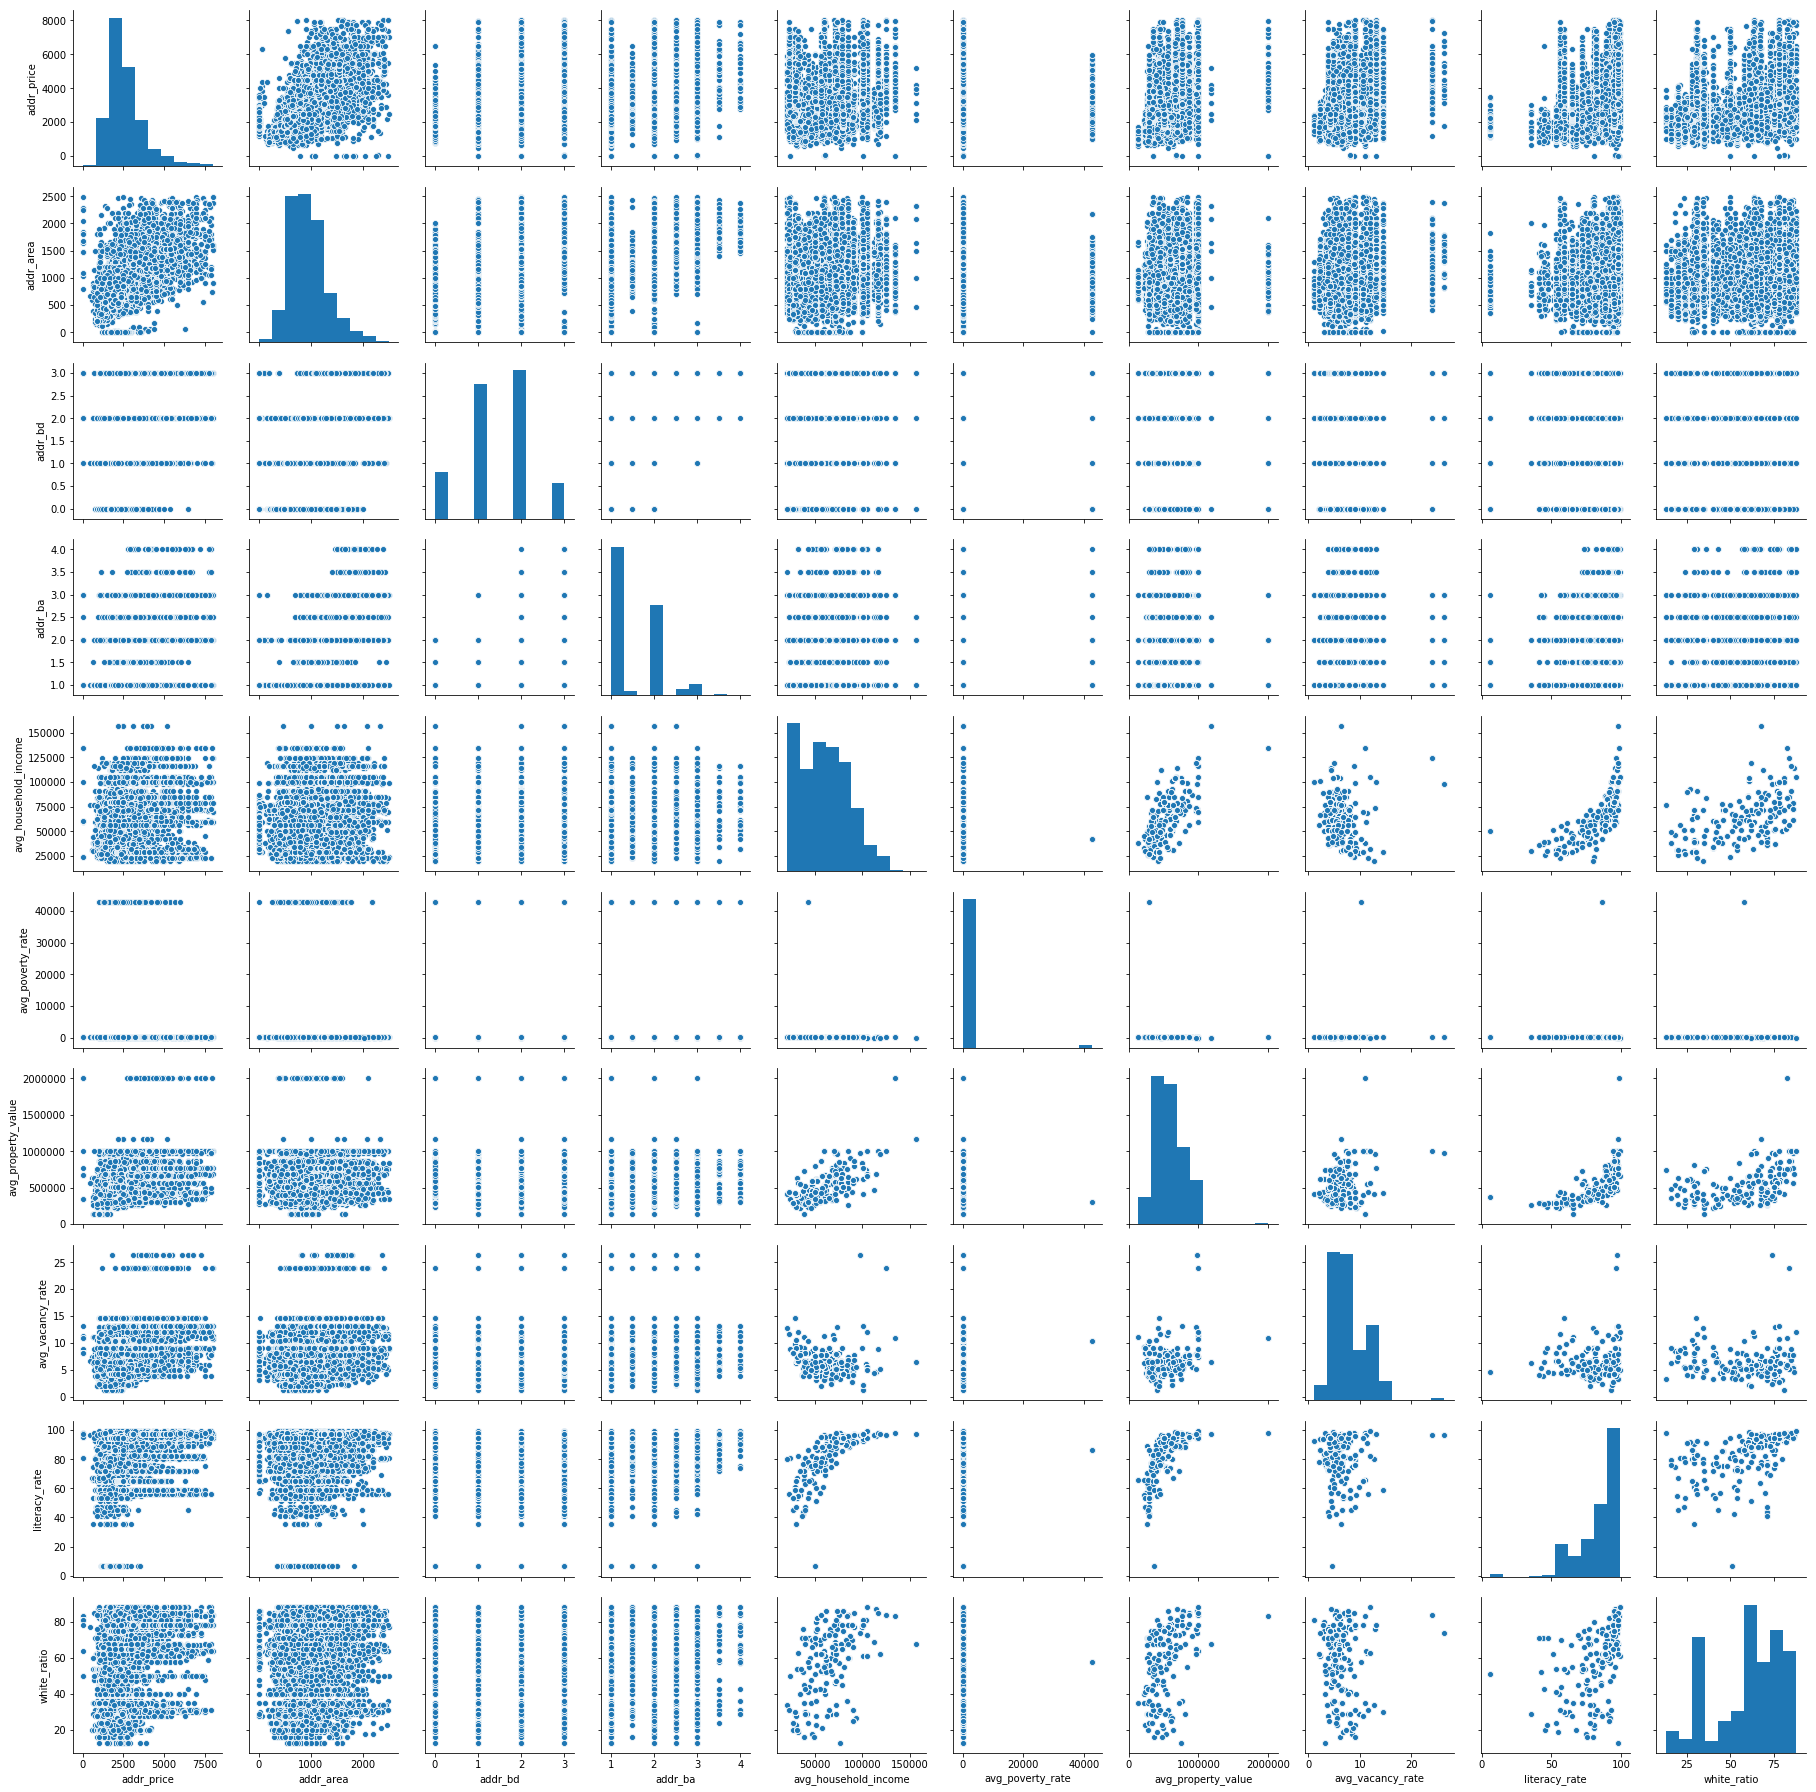

In [87]:
# understand relationships between different variables
sns.pairplot(super_model_data[cols_to_analyze].dropna())

c:\users\windows10\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


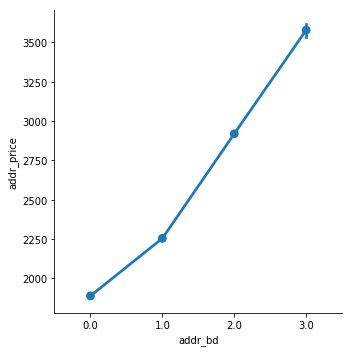

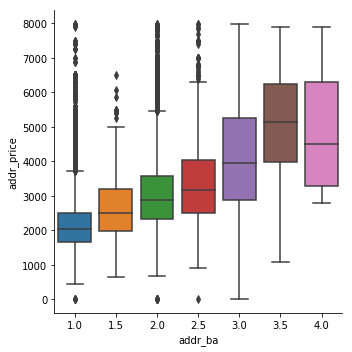

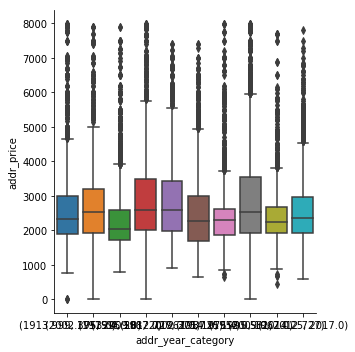

In [88]:
# factorplots
print(sns.factorplot(kind='point', x='addr_bd', y='addr_price', data=super_model_data[cols_to_analyze]))
print(sns.factorplot(kind='box', x='addr_ba', y='addr_price', data=super_model_data[cols_to_analyze]))
print(sns.factorplot(kind='box', x='addr_year_category', y='addr_price', data=super_model_data[cols_to_analyze]))

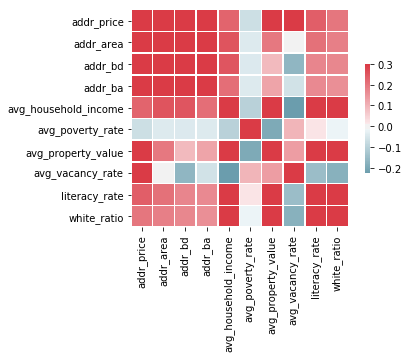

In [89]:
# correlation matrix
corr_data = super_model_data[cols_to_analyze].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_data, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [90]:
## Actual modeling

In [91]:
# generate model input and output data
features_to_use = ['addr_zip', 'addr_bd', 'addr_ba', 'addr_area', 'addr_year_category']
Y = super_model_data['addr_price'].copy()
model_data = pd.get_dummies(columns=['addr_zip', 'addr_bd', 'addr_ba', 'addr_year_category'], data=super_model_data[features_to_use], drop_first=True)  # categorical data
model_data = model_data.dropna().reset_index(drop=True)
print("Data dimensions:", model_data.shape)

Data dimensions: (43261, 183)


In [92]:
## define cross-validation parameters
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [93]:
temp_model_data = model_data[model_data['addr_bd_3.0'] == 1].reset_index(drop=True)
temp_Y = Y[model_data['addr_bd_3.0'] == 1].reset_index(drop=True)
temp_model_data.shape

(4193, 183)

In [94]:
## evaluate Ridge Regression model
mse = []
r2 = []
cone = []
for train_index, test_index in kf.split(temp_model_data):
    train_data = model_data.iloc[train_index]
    train_Y = Y.iloc[train_index]
    test_data = model_data.iloc[test_index]
    test_Y = Y.iloc[test_index]
    model1 = linear_model.Ridge().fit(train_data, train_Y)
    mse.append(metrics.mean_squared_error(model1.predict(test_data), test_Y))
    r2.append(model1.score(test_data, test_Y))
    cone.append(cone_metric(y_true=test_Y, y_pred=model1.predict(test_data), tolerance=0.15))
print("Mean R-squared:", np.mean(r2))
print("Stdev R-squared:", np.std(r2))
print("Mean 15% cone:", np.mean(cone)) 
print("Stdev 15% cone:", np.std(cone))

Mean R-squared: 0.6835939483291773
Stdev R-squared: 0.015178458309942638
Mean 15% cone: 0.7290765515259956
Stdev 15% cone: 0.011815298472030254


In [95]:
## evaluate Extra Trees model
mse = []
r2 = []
cone = []
for train_index, test_index in kf.split(model_data):
    train_data = model_data.iloc[train_index]
    train_Y = Y.iloc[train_index]
    test_data = model_data.iloc[test_index]
    test_Y = Y.iloc[test_index]
    print(test_Y.shape)
    test_Y = test_Y[test_data['addr_bd_3.0'] == 1].reset_index(drop=True)
    test_data = test_data[test_data['addr_bd_3.0'] == 1].reset_index(drop=True)
    print(test_Y.shape)
    model1 = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=50).fit(train_data, train_Y)
    mse.append(metrics.mean_squared_error(model1.predict(test_data), test_Y))
    r2.append(model1.score(test_data, test_Y))
    cone.append(cone_metric(y_true=test_Y, y_pred=model1.predict(test_data), tolerance=0.15))
print("Mean R-squared of Random Forest:", np.mean(r2))
print("Stdev R-squared of Random Forest:", np.std(r2))
print("Mean 15% cone of Random Forest:", np.mean(cone))
print("Stdev 15% cone of Random Forest:", np.std(cone))

(8653,)
(871,)
(8652,)
(803,)
(8652,)
(819,)
(8652,)
(844,)
(8652,)
(856,)
Mean R-squared of Random Forest: 0.860585002868293
Stdev R-squared of Random Forest: 0.027782193164030255
Mean 15% cone of Random Forest: 0.8699024711693026
Stdev 15% cone of Random Forest: 0.016997967576845557


In [96]:
model2 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=50).fit(model_data, Y)
joblib.dump(model2, 'models/a_extra_trees.pkl')
joblib.dump(model_data.columns.values, 'models/a_feature_names.pkl')
joblib.dump(Y, 'data/Y.pkl')
joblib.dump(model_data, 'data/model_data.pkl')


['data/model_data.pkl']

In [97]:
## evaluate Random Forest model - Method 2
model1 = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
scoring_methods = {
    'R-squared': 'r2',
    'Cone (15%)': cone_score(tolerance=0.15)
}
model1_scores = model_selection.cross_validate(model1,
                                               model_data, Y,
                                               cv=kf.split(model_data),
                                               scoring=scoring_methods,
                                               return_train_score=False)
print("Mean R-squared of Random Forest:", model1_scores['test_R-squared'].mean())
print("StdDev R-squared of Random Forest:", model1_scores['test_R-squared'].std())
print("Mean Cone Performance (15%) of Random Forest:", model1_scores['test_Cone (15%)'].mean())
print("StdDev Cone Performance (15%) of Random Forest:", model1_scores['test_Cone (15%)'].std())

Mean R-squared of Random Forest: 0.8705377611480355
StdDev R-squared of Random Forest: 0.005129357121587578
Mean Cone Performance (15%) of Random Forest: 0.8617000301179086
StdDev Cone Performance (15%) of Random Forest: 0.0030583047290958735


In [98]:
# evaluate GBM Regression model
model1 = xgboost.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
                      learning_rate=0.1, max_delta_step=0, max_depth=3,
                      min_child_weight=1, missing=None, n_estimators=100,
                      objective='reg:linear', reg_alpha=0, reg_lambda=1,
                      scale_pos_weight=1, seed=0, silent=True, subsample=1)
scoring_methods = {
    'R-squared': 'r2',
    'Cone (15%)': cone_score(tolerance=0.15)
}
model1_scores = model_selection.cross_validate(model1,
                                               model_data, Y,
                                               cv=kf.split(model_data),
                                               scoring=scoring_methods,
                                               return_train_score=False)
print("Mean R-squared of Random Forest:", model1_scores['test_R-squared'].mean())
print("StdDev R-squared of Random Forest:", model1_scores['test_R-squared'].std())
print("Mean Cone Performance (15%) of Random Forest:", model1_scores['test_Cone (15%)'].mean())
print("StdDev Cone Performance (15%) of Random Forest:", model1_scores['test_Cone (15%)'].std())

Mean R-squared of Random Forest: 0.6487375789553426
StdDev R-squared of Random Forest: 0.009773553164447992
Mean Cone Performance (15%) of Random Forest: 0.5195903905652137
StdDev Cone Performance (15%) of Random Forest: 0.004081130894374712


In [99]:
# # determine where residual errors are the most
# model1 = linear_model.Lasso().fit(train_data, train_Y)
# print model1.score(test_data, test_Y)
# residuals = model1.predict(test_data) - test_Y
# test_df = pd.DataFrame({'Predicted': model1.predict(test_data), 'Actual': test_Y, 'Error': residuals})
# test_df.join(crawl_data6_valid.iloc[test_index][['addr_area', 'addr_zip', 'addr_bd', 'addr_ba', 'sortaddress']]).sort_values(by='Error', ascending=False).head()

In [100]:
### find out averages in area
print(super_model_data[(super_model_data.addr_zip == 91801) & (super_model_data.addr_bd < 2)].groupby(by=['addr_zip', 'addr_bd', 'addr_ba'])[['addr_year_category']].describe())
print(super_model_data[(super_model_data.addr_zip == 91801) & (super_model_data.addr_bd < 2)].groupby(by=['addr_zip', 'addr_bd', 'addr_ba'])[['addr_price']].describe())
print(super_model_data[(super_model_data.addr_zip == 91801) & (super_model_data.addr_bd < 2)].groupby(by=['addr_zip', 'addr_bd', 'addr_ba'])[['addr_area']].describe())

                         addr_year_category                                
                                      count unique                 top freq
addr_zip addr_bd addr_ba                                                   
91801    0.0     1.0                     13      1  (1987.0, 1995.581)   13
         1.0     1.0                     62      3    (1953.0, 1967.0)   56
                 2.0                      2      1    (1953.0, 1967.0)    2
                         addr_price                                                                 
                              count         mean         std     min     25%     50%     75%     max
addr_zip addr_bd addr_ba                                                                            
91801    0.0     1.0           13.0  1520.000000  385.400225  1150.0  1290.0  1540.0  1540.0  2320.0
         1.0     1.0           62.0  1655.725806  431.223504   775.0  1450.0  1500.0  1650.0  2695.0
                 2.0            2.0  22

In [101]:
# pd.concat([super_model_data[['addr_price']], model_data_nlp[(super_model_data.addr_zip == 91801) & (super_model_data.addr_bd < 2)][['addr_area', 'addr_bd_1.0', 'addr_zip_91801', 'air conditioning', 'cats allowed', 'dogs allowed', 'storage', 'washer dryer', 'pool',
#                  'outdoor space', 'laundry', 'gated', 'hardwood', 'garage', 'fitness', 'dishwasher',
#                  'covered', 'balcony']]], axis=1, join='inner')

In [102]:
#### use model for prediction
model1 = linear_model.Ridge().fit(model_data, Y)

In [115]:
## TEST 1
# generate test dataframe
test_df = pd.DataFrame(data=None, columns=model_data.columns)
# add test data
new_data = [{'addr_area': 850, 'addr_bd_2.0': 1, 'addr_zip_91103': 1},
            {'addr_area': 490, 'addr_bd_1.0': 1, 'addr_zip_91103': 1},
            {'addr_area': 350, 'addr_zip_91103': 1}]
test_data = test_df.append(new_data).fillna(0)
# make predictions
mypred = model1.predict(test_data)
print("Individual unit predictions:", mypred)
print("Cummulative prediction:", (mypred[0]*2 + mypred[1]*6 + mypred[2]*4)*12)

Individual unit predictions: [2306.94003742 1765.08374734 1434.35279743]
Cummulative prediction: 251301.52498335106


In [116]:
## Feature effects
print(model1.intercept_)
pd.DataFrame({'param': model_data.columns.values, 'coef': model1.coef_}).values

583.9787759406099


array([['addr_area', 1.438191837589855],
       ['addr_zip_90004', 305.04530570833214],
       ['addr_zip_90005', 430.29165833906666],
       ['addr_zip_90006', 99.88304419487409],
       ['addr_zip_90011', -214.89909744991758],
       ['addr_zip_90012', 520.5866642739217],
       ['addr_zip_90013', 530.7955227037962],
       ['addr_zip_90014', 1022.6654722818105],
       ['addr_zip_90015', 826.1934902982947],
       ['addr_zip_90017', 842.0248553788027],
       ['addr_zip_90020', 399.95759350196784],
       ['addr_zip_90022', -491.53150477190866],
       ['addr_zip_90023', -507.6544673975237],
       ['addr_zip_90024', 1262.5842441754191],
       ['addr_zip_90025', 748.964344812155],
       ['addr_zip_90026', 398.61197947893913],
       ['addr_zip_90027', 288.5649359861871],
       ['addr_zip_90028', 886.6807863928416],
       ['addr_zip_90034', 448.78773436292687],
       ['addr_zip_90035', 406.0430018037815],
       ['addr_zip_90036', 644.6210370005329],
       ['addr_zip_90037', -1

In [103]:
# Model 1 with NLP

# Use best model above with NLP features extracted previously.

In [104]:
from scipy.sparse import hstack
from sklearn import model_selection

In [105]:
## choose text features for model
text_features = ['air conditioning', 'cats allowed', 'dogs allowed', 'garage']
text_features_to_use = [names_amenities_idx[i] for i in text_features]
X_text_features = X_amenities[:, text_features_to_use]

In [106]:
## concatenate text features to use with model data
# # method 1 - loses variable names
# X = hstack((X_text_features, model_data)).toarray()
# # method 2 - keeps variable names
vect_df = pd.DataFrame(X_text_features.todense(), columns=text_features)
model_data_nlp = pd.concat([model_data, vect_df], axis=1)
# model_data_nlp = model_data.copy()
# ## add anomalous features
# # in-unit laundry and laundry on premises
laundry_in_unit_flag = (usable_data.amenities.apply(find_string, args=('dryer',)) | usable_data.amenities.apply(find_string, args=('laundry.{0,2}in.?unit',)))
laundry_on_site_flag = (usable_data.amenities.apply(find_string, args=('laundry',)) & ~laundry_in_unit_flag)
model_data_nlp['laundry_in_unit'] = laundry_in_unit_flag
# model_data_nlp['laundry_on_site'] = laundry_on_site_flag

In [107]:
print(model_data.shape)
print(model_data_nlp.shape)
print(super_model_data.shape)
print(usable_data.shape)

(43261, 183)
(43261, 188)
(43261, 14)
(43261, 37)


In [108]:
temp_model_data_nlp = model_data_nlp[model_data_nlp['addr_bd_3.0'] == 1].reset_index(drop=True)
temp_Y = Y[model_data_nlp['addr_bd_3.0'] == 1].reset_index(drop=True)
temp_model_data_nlp.shape

(4193, 188)

In [109]:
# define cross-validation parameters
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [123]:
# test performance of Random Forest NLP model
model1_nlp = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
model2_nlp = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=50)
scoring_methods = {
    'R-squared': 'r2',
    'Cone (15%)': cone_score(tolerance=0.15)
}
model1_nlp_scores = model_selection.cross_validate(model2_nlp,
                                                   temp_model_data_nlp, temp_Y,
                                                   cv=kf.split(temp_model_data_nlp),
                                                   scoring=scoring_methods,
                                                   return_train_score=True)
print("Mean R-squared of Random Forest:", model1_nlp_scores['test_R-squared'].mean())
print("StdDev R-squared of Random Forest:", model1_nlp_scores['test_R-squared'].std())
print("Mean Cone Performance (15%) of Random Forest:", model1_nlp_scores['test_Cone (15%)'].mean())
print("StdDev Cone Performance (15%) of Random Forest:", model1_nlp_scores['test_Cone (15%)'].std())

Mean R-squared of Random Forest: 0.8623966193275534
StdDev R-squared of Random Forest: 0.045508027517401885
Mean Cone Performance (15%) of Random Forest: 0.8769383940991234
StdDev Cone Performance (15%) of Random Forest: 0.005068160879167126


In [110]:
model2_nlp = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=50).fit(temp_model_data_nlp, temp_Y)
joblib.dump(model2_nlp, 'models/b_extra_trees_nlp.pkl')
joblib.dump(model_data_nlp.columns.values, 'models/b_feature_names.pkl')
# joblib.dump(model_data_nlp, 'data/model_data_nlp.pkl')

['models/b_feature_names.pkl']

In [112]:
# model1_nlp_scores

In [113]:
#### use NLP model for prediction
# model fit
model1_nlp = ensemble.RandomForestRegressor(verbose=1, n_jobs=-1).fit(temp_model_data_nlp, temp_Y)
# model1_nlp

In [114]:
pd.DataFrame({'feature': model_data_nlp.columns.values, 'importance': model1_nlp.feature_importances_}).sort_values('importance', ascending=False)

In [119]:
## TEST 1
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 1991, 'addr_bd_3.0': 1, 'addr_bd_2.0': 1, 'addr_zip_90201': 1, 'air conditioning': 1},
            {'addr_area': 490, 'addr_bd_1.0': 1, 'addr_zip_91103': 1, 'air conditioning': 1},
            {'addr_area': 350, 'addr_zip_91103': 1, 'air conditioning': 1}]
test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model2_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", (mypred_nlp[0]*2 + mypred_nlp[1]*6 + mypred_nlp[2]*4)*12)

Individual unit predictions: [3574.22 2384.8  2459.35]
Cummulative prediction: 375535.68


In [115]:
## TEST 2
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 325, 'addr_zip_91801': 1, 'air conditioning': 1, 'dogs allowed': 1, 'cats allowed': 1, 'laundry_in_unit': 1, 'garage': 1},
            {'addr_area': 450, 'addr_bd_1.0': 1, 'addr_zip_91801': 1, 'air conditioning': 1, 'dogs allowed': 1, 'cats allowed': 1, 'laundry_in_unit': 1, 'garage': 1}]

test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model1_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", (mypred_nlp[0]*24 + mypred_nlp[1]*12)*12)

In [123]:
## TEST 3 - 1905 Vassar, Glendale 91204
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 750, 'addr_zip_91204': 1, 'addr_bd_1.0': 1, 'air conditioning': 1, 'laundry_in_unit': 1},
                {'addr_area': 840, 'addr_zip_91204': 1, 'addr_bd_2.0': 1, 'air conditioning': 1, 'laundry_in_unit': 1},
                {'addr_area': 845, 'addr_zip_91204': 1, 'addr_bd_2.0': 1, 'addr_ba_2.0': 1, 'air conditioning': 1,  'laundry_in_unit': 1}]
test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model1_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", (mypred_nlp[0]*4 + mypred_nlp[1]*1 + mypred_nlp[2]*2)*12)

Individual unit predictions: [2225.16666667 2225.16666667 2453.        ]
Cummulative prediction: 192382.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [394]:
## TEST 4 - ca 91204, glendale, 914 s central ave
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 463, 'addr_zip_91204': 1, 'addr_year_category_(1960.136, 1965.0)': 1, 'air conditioning': 1, 'laundry_in_unit': 1, 'garage': 1},
                {'addr_area': 716, 'addr_zip_91204': 1, 'addr_year_category_(1960.136, 1965.0)': 1, 'addr_bd_1.0': 1, 'air conditioning': 1, 'laundry_in_unit': 1, 'garage': 1},
                {'addr_area': 886, 'addr_zip_91204': 1, 'addr_year_category_(1960.136, 1965.0)': 1, 'addr_bd_2.0': 1, 'air conditioning': 1, 'laundry_in_unit': 1, 'garage': 1}]
test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model1_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", (mypred_nlp[0]*2 + mypred_nlp[1]*46 + mypred_nlp[2]*4)*12)

Individual unit predictions: [2548. 2108. 2058.]
Cummulative prediction: 1323552.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [395]:
## TEST 5 - 1021 12th St Unit 110, Santa Monica 90403
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 1337, 'addr_zip_90403': 1, 'addr_bd_2.0': 1, 'addr_ba_2.0': 1, 'addr_year_category_(1970.277, 1975.521)': 1, 'dogs allowed': 1, 'cats allowed': 1, 'garage': 1}]
test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model1_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", mypred_nlp[0]*12)

Individual unit predictions: [3877.95833333]
Cummulative prediction: 46535.5


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [396]:
## TEST 6 - 11835 Vanowen St Unit 110, Santa Monica 90403
# generate test dataframe
test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
# add test data
new_data_nlp = [{'addr_area': 1005, 'addr_zip_91605': 1, 'addr_bd_2.0': 1, 'addr_ba_2.0': 1, 'addr_year_category_(2006.0, 2016.0)': 1, 'garage': 1},]
test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
# make predictions
mypred_nlp = model1_nlp.predict(test_data_nlp)
print("Individual unit predictions:", mypred_nlp)
print("Cummulative prediction:", mypred_nlp[0]*10*12)

Individual unit predictions: [2384.]
Cummulative prediction: 286080.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [128]:
# super_model_data[(super_model_data.addr_bd == 1) & (super_model_data.addr_zip == 90731)].groupby(['addr_zip', 'addr_year_category'])[['addr_price', 'addr_area']].describe()

addr_price                                                                   addr_area                                                             
                                 count         mean         std     min      25%     50%     75%     max     count       mean         std    min     25%    50%     75%     max
addr_zip addr_year_category                                                                                                                                                    
90731    (1913.999, 1953.0)       62.0  1631.419355  453.721354  1100.0  1296.25  1472.5  1850.0  2800.0      62.0  685.16129  238.963348  390.0  515.75  620.5  743.75  1617.0

In [116]:
avg_info = super_model_data.groupby(['addr_zip','addr_year_category', 'addr_bd'])[['addr_price', 'addr_area']].describe()

In [117]:
joblib.dump(avg_info, 'data/avg_info.pkl')

['data/avg_info.pkl']

In [119]:
## measure performance at the ZIP code level
# zip_list = super_model_data.addr_zip.unique()
# perf_zip = []
# for each_zip in zip_list:
#     test_df_nlp = pd.DataFrame(data=None, columns=model_data_nlp.columns)
#     new_data_nlp = model_data_nlp[super_model_data.addr_zip == each_zip].reset_index(drop=True)
#     test_data_nlp = test_df_nlp.append(new_data_nlp).fillna(0)
#     mypred_nlp = model1_nlp.predict(test_data_nlp)
#     perf_cone = cone_metric(y_true=super_model_data[(super_model_data.addr_zip == each_zip)].addr_price, y_pred=mypred_nlp, tolerance=0.15)
#     perf_zip.append(perf_cone)
# count_zip = [(super_model_data.addr_zip == each_zip).sum() for each_zip in zip_list]
# cone_zip = pd.DataFrame({'zip': zip_list, 'unit_count': count_zip, 'performance_0.15': perf_zip})
# cone_zip.to_csv('performance_15pct_zip.csv', index=False)

In [120]:
# assessor_data[assessor_data.sortaddress.apply(find_string,args=('91. s central',))][['FIPS', 'PropertyID', 'sortaddress', 'SumBuildingSqFt', 'SumLivingAreaSqFt', 'SumGrossAreaSqFt', 'SumAdjAreaSqFt', 'SumBasementSqFt', 'SumGarageSqFt', 'EffectiveYearBuilt', 'SumResidentialUnits', 'TotalRooms', 'Bedrooms', 'BathTotalCalc']]

In [121]:
laundry_list = usable_data[(usable_data.amenities.apply(find_string, args=(' washer ',))) & (usable_data.link.apply(find_string, args=('hotpads.com',)))]['amenities'].apply(lambda x: re.findall('(.{0,20} washer.{0,20})', x, flags=re.IGNORECASE))
sort_and_deduplicate(laundry_list)

[['y refrigerator newly washer and dryer one year '],
 ['y amenities Laundry: Washer & Dryer On-Site sec'],
 ['y amenities Laundry: Washer & Dryer On-Site one'],
 ['y amenities Laundry: Washer & Dryer On-Site gra'],
 ['y amenities Laundry: Washer & Dryer On-Site gat'],
 ['y amenities Laundry: Washer & Dryer On-Site cov'],
 ['y amenities Laundry: Washer & Dryer On-Site bli'],
 ['y amenities Laundry: Washer & Dryer On-Site ass'],
 ['y amenities Laundry: Washer & Dryer On-Site Wat'],
 ['y amenities Laundry: Washer & Dryer On-Site Uti'],
 ['y amenities Laundry: Washer & Dryer On-Site Pat'],
 ['y amenities Laundry: Washer & Dryer On-Site Par'],
 ['y amenities Laundry: Washer & Dryer On-Site'],
 ['y Small Dogs Allowed Washer Water included in r'],
 ['y Small Dogs Allowed Washer Unit amenities Atta'],
 ["wood Farmer's Market Washer and Dryer (in selec"],
 ['way. View Type: City Washer Unit amenities GAS '],
 ['washer Microwave and Washer and Dryer Refrigera'],
 ['ve Refrigerator View Washer W

In [122]:
usable_data[usable_data.link.apply(find_string, args=('apartments.com',)) & usable_data.amenities.apply(find_string, args=('dryer',))][['link', 'amenities']].head().values

array([['https://www.apartments.com/736-colman-st-altadena-ca/1zyxk97/',
        'Pet Policy Dogs Allowed Parking Garage Lease Length 12 Months Features •Washer/Dryer'],
       ['https://www.apartments.com/2131-navarro-ave-altadena-ca/h9z1xs3/',
        'Pet Policy No Pets Allowed Parking Street Lease Length 12 Month Features •Washer/Dryer •Smoke Free'],
       ['https://www.apartments.com/areum-apartments-monrovia-ca/8k4tne3/',
        'Unique Features •BLISS: Resort-style Pool and Spa •Brand New Apartments •Framed Vanity Mirrors •Front-loading Washer and Dryer •HAVEN: Social Lounge •Kitchen Islands* •MIX & MINGLE: Outdoor Fireplace Lounge •Mosaic Tile Kitchen Backsplash •Polished Quartz Countertops •Private Cover Patio* •TRANSCEND: Fitness Center •Wood-look Plank Flooring in Living Space Pet Policy Dogs Allowed: Areum welcomes dogs and cats, including puppies and kittens! Breed restrictions do apply, so please call for specific breed and weight restrictions, and deposits and fees. *W